# Custom modules

In [9]:
import os
import sys
# Custom modules: add the 'lib' directory as one where we can import modules
# lib_src = os.path.join(os.getcwd(), os.pardir, 'src')
lib_src = '\\Users\\mauricio\\gdrive\\python\\machine-learning'
sys.path.insert(1, lib_src)
from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache

# Standard modules

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('dark_background')
#sns.set()
import pandas as pd
import numpy as np
from time import time
from scipy.stats import zscore
import psutil
import gc

# Exploring training data

## Load a view data

In [11]:
df = pd.read_csv('../data/TrainingData.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

One can see a random uniform row index sampling in the training data

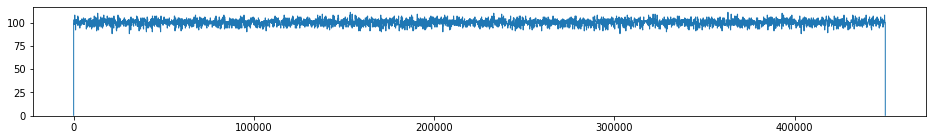

In [12]:
plt.figure(figsize=(16,2))
plt.hist(df.index, bins=4000, histtype='step')
plt.show()

Multi-class multi-label examples

According to [https://www.drivendata.org/competitions/4/box-plots-for-education/page/15/#labels_list] the labels are handled in alphabetical order.

In [13]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
df[LABELS].head(5).transpose()

,134338,206341,326408,364634,47683
Function,Teacher Compensation,NO_LABEL,Teacher Compensation,Substitute Compensation,Substitute Compensation
Object_Type,NO_LABEL,NO_LABEL,Base Salary/Compensation,Benefits,Substitute Compensation
Operating_Status,PreK-12 Operating,Non-Operating,PreK-12 Operating,PreK-12 Operating,PreK-12 Operating
Position_Type,Teacher,NO_LABEL,Teacher,Substitute,Teacher
Pre_K,NO_LABEL,NO_LABEL,Non PreK,NO_LABEL,NO_LABEL
Reporting,School,NO_LABEL,School,School,School
Sharing,School Reported,NO_LABEL,School Reported,School Reported,School Reported
Student_Type,NO_LABEL,NO_LABEL,Unspecified,Unspecified,Unspecified
Use,Instruction,NO_LABEL,Instruction,Instruction,Instruction


Every column else is a potential feature

In [14]:
FEATURES = [feature for feature in df.columns if feature not in LABELS]
df[FEATURES].head(5).transpose()

,134338,206341,326408,364634,47683
Object_Description,NaN,CONTRACTOR SERVICES,Personal Services - Teachers,EMPLOYEE BENEFITS,TEACHER COVERAGE FOR TEACHER
Text_2,NaN,BOND EXPENDITURES,NaN,TEACHER SUBS,TEACHER SUBS
SubFund_Description,NaN,BUILDING FUND,NaN,GENERAL FUND,GENERAL FUND
Job_Title_Description,Teacher-Elementary,(blank),TCHER 2ND GRADE,"Teacher, Short Term Sub","Teacher, Secondary (High)"
Text_3,NaN,Regular,NaN,Regular,Alternative
Text_4,NaN,NaN,Regular Instruction,NaN,NaN
Sub_Object_Description,NaN,NaN,NaN,NaN,NaN
Location_Description,NaN,NaN,NaN,NaN,NaN
FTE,1,NaN,1,NaN,NaN
Function_Description,NaN,RGN GOB,NaN,UNALLOC BUDGETS/SCHOOLS,NON-PROJECT


Numeric features examples

In [15]:
NUMERIC_FEATURES = ['FTE', 'Total']
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
df[NUMERIC_FEATURES].head(15).transpose()

,134338,206341,326408,364634,47683,229958,417668,126378,275539,85262,304569,330504,84272,64760,21870
FTE,1.00,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.60,NaN,0.00
Total,50471.81,3477.86,62237.13,22.3,54.166,-8.15,2000.05,0.72,228.25,69.56,-5509.32,16.41,38824.79,-122544.07,228.53


## Missing values

Overall count and proportion of missing data

In [16]:
missing = df.isnull()
missing.sum().sum(), missing.sum().sum() / (df.shape[0] * df.shape[1])

(2942109, 0.29400729994478825)

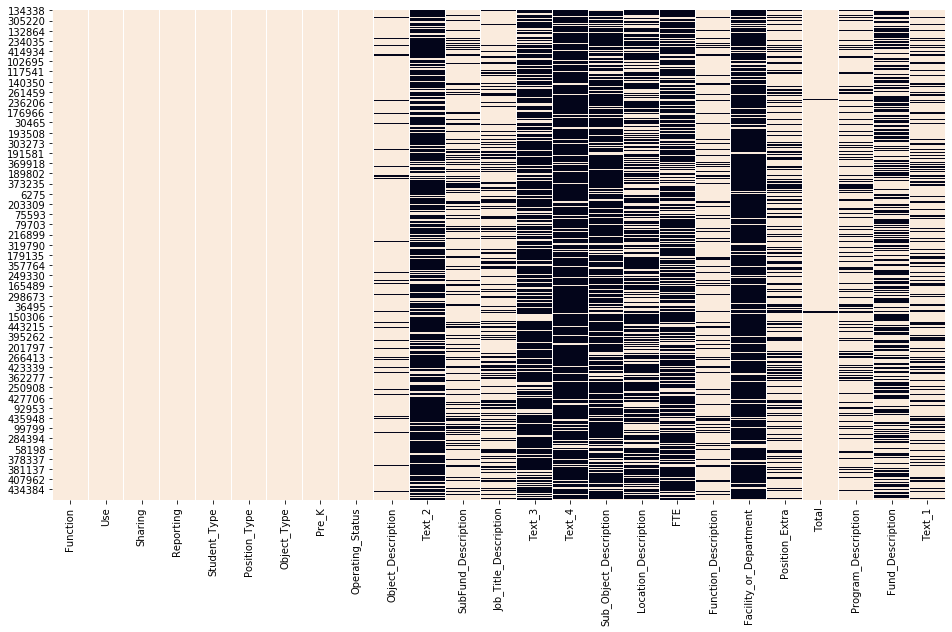

In [17]:
plt.figure(figsize=(16,9))
sns.heatmap(~missing, cbar=False)
plt.show()

### Missing features

Missing report function: Count and proportion of missing data per column

In [18]:
def missing_report(df):
    area = (df.shape[0]*(df.shape[1]))
    proportion = lambda x: x.sum() / area
    missing = df.isnull().agg(['sum', 'mean', proportion]).transpose()
    missing = missing.sort_values('sum', ascending=False)
    missing.columns = ['ocurrences', 'column proportion', 'overall proportion']
    missing['ocurrences'] = missing.ocurrences.astype('int')
    return missing

In [19]:
missing_report(df[FEATURES])

,ocurrences,column proportion,overall proportion
Text_4,346531,0.865728,0.054108
Facility_or_Department,346391,0.865378,0.054086
Text_2,312060,0.779610,0.048726
Sub_Object_Description,308674,0.771151,0.048197
Text_3,291125,0.727309,0.045457
FTE,274206,0.685041,0.042815
Location_Description,238223,0.595145,0.037197
Fund_Description,197400,0.493158,0.030822
Position_Extra,135513,0.338548,0.021159
Text_1,107992,0.269793,0.016862


The numeric variable `FTE` lacks `68%` and `Total` lacks only `1%`.  The most frequent text column is `Object Description`.

### **Missing `FTE`**

Let's subtotal missing `FTE` by `Object Description`: One can see high ocurrence of 'EMPLOYEE BENEFITS', similar objects and also 'SUPPLIES'.

In [20]:
df.fillna({'Object_Description':'NaN'}).loc[df.FTE.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                    47495
CONTRA BENEFITS                      19381
ADDITIONAL/EXTRA DUTY PAY/STIP       16841
SUPPLIES                             13117
RETIREMENT CONTRIB.                  13073
                                     ...  
TRANSPORTATION DIVISION CONTRACTS        1
INTERFUND                                1
TRANSFERS TO ENTERPRISE FUNDS            1
SECURITY SERVICES                        1
OTHER MATERIALS AND SUPPLIES             1
Length: 555, dtype: int64

Let's list `Total` related to missing `FTE`: High `Total` values, like 129,7 millions, not related to (missing) `FTE`.

In [21]:
df.loc[df.FTE.isnull(), ['Total', 'Object_Description']].sort_values('Total', ascending=False)

,Total,Object_Description
358538,1.297000e+08,Payments to a Community School*
322149,5.323797e+07,Other Purchased Services
390959,4.789057e+07,PAYMENTS TO ESCROW AGENTS
177775,3.956446e+07,INTEREST ON LEASES
331752,3.645094e+07,BUILDINGS
...,...,...
300250,NaN,EMPLOYEE BENEFITS
289753,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,EMPLOYEE BENEFITS
334668,NaN,EMPLOYEE BENEFITS


### **Missing `Total`**

Let's subtotal missing `Total` by `Object Description`:  One can see high occurrence in 'EMPLOYEE BENEFITS' and related objects.

In [22]:
df.fillna({'Object_Description':'NaN'}).loc[df.Total.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                                     1184
SALARIES OF REGULAR EMPLOYEES                          876
EMPLOYER PD MED CONTRIBUTION                           295
Salaries And Wages For Teachers And Other Professi     288
NaN                                                    261
                                                      ... 
LIABILITY INSURANCE                                      1
LIBRARY BOOKS                                            1
LIBRARY BOOKS                                            1
MAINTENANCE OF SOFTWARE                                  1
OTHER PURCHASED SERVICES                                 1
Length: 217, dtype: int64

Let's list `FTE` related to missing `Total`: Highest `FTE` values, close to 1, whose missing `Total` is not clear.

In [23]:
df.loc[df.Total.isnull(), ['FTE', 'Object_Description']].sort_values('FTE', ascending=False)

,FTE,Object_Description
392540,1.127804,SALARIES OF REGULAR EMPLOYEES
147244,1.016335,SALARIES OF REGULAR EMPLOYEES
91088,1.012847,SALARIES OF REGULAR EMPLOYEES
60354,1.012223,SALARIES OF REGULAR EMPLOYEES
203019,1.009218,SALARIES OF REGULAR EMPLOYEES
...,...,...
300250,NaN,EMPLOYEE BENEFITS
289753,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,EMPLOYEE BENEFITS
334668,NaN,EMPLOYEE BENEFITS


### **No missing labels**

No label has missing data

In [24]:
missing[LABELS].all().all()

False

However, there is a hierarchical relationship for these labels. If a line is marked as `'Non-Operating'` in the `Operating_Status` category, then all of the other labels should be marked as `'NO_LABEL'` since ERS does not analyze and compare non-operating budget items.

In [25]:
other_labels = [l for l in LABELS if l !='Operating_Status']
df[df.Operating_Status=='Non-Operating'].groupby(['Operating_Status'] + other_labels).size()

Operating_Status  Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating     NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
dtype: int64

Reversely, checking which `Operating_Status` come along with all other labels marked as `'NO_LABEL'`.

In [26]:
Nolabel_Operating_Status = df[(df[other_labels]=='NO_LABEL').all(axis=1)].groupby('Operating_Status').size()
Nolabel_Operating_Status.index.tolist()

['Non-Operating', 'Operating, Not PreK-12']

In [27]:
df[df.Operating_Status.isin(Nolabel_Operating_Status.index.tolist())].groupby(['Operating_Status'] + other_labels).size()

Operating_Status        Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating           NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
Operating, Not PreK-12  NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL     8665
dtype: int64

The same relationship were found when `Operating_Status` is '`Operating, Not PreK-12`'

## Continuous variables: FTE and Total

`FTE`: full-time equivalent
If the budget item is associated to an employee, this number tells us the **percentage** of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

`Total`: total cost of the expenditure.
This number tells us how much the budget item cost.

In [28]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


Function to plot a panel with a scatter, density and box plots:

In [29]:
from scipy.stats import zscore
def density_plots(x, label=None, outlying = True, zthreshold = 3):

    if outlying:
        x_mean = x.mean()
        x_std = x.std()
        lower_limit = x_mean - zthreshold * x_std
        upper_limit = x_mean + zthreshold * x_std
        outliers = x[(zscore(x) < -zthreshold) | (zscore(x) > zthreshold)]
    
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1); plt.grid(False)
    plt.plot(x, marker='.', linestyle='none', color='green', label='not outlier')
    plt.ylabel(label); plt.xlabel('row')
    
    if outlying:
        plt.plot(outliers, marker='.', linestyle='none', color='red', label='outlier')
        plt.axhline(lower_limit, linestyle='dotted', color='red', label='outlier limits')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')
    
    plt.subplot(1,3,2); plt.grid(False)
    sns.distplot(x)
    plt.xlabel(label); plt.ylabel('PDF')
    
    if outlying:
        plt.axvline(lower_limit, linestyle='dotted', color='red', label='outlier limits')
        plt.axvline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')
    
    plt.subplot(1,3,3); plt.grid(False)
    sns.boxplot(x, orient='v')
    plt.ylabel(label)
    plt.xticks=False
    
    if outlying:
        plt.axhline(lower_limit, linestyle='dotted', color='red', label='outlier limits')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')
        
    plt.tight_layout()
    plt.show()

### `FTE` univariate analysis

`FTE` contains skewed data with upper outliers

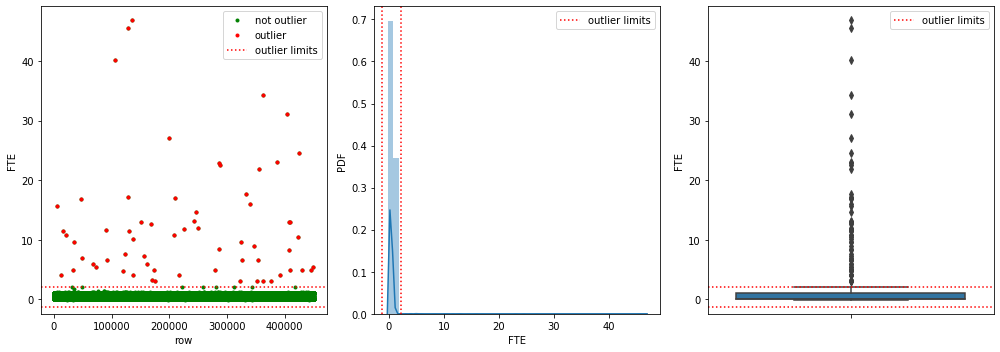

Upper outliers: 64
Lower outliers: 0


In [30]:
fte = df.FTE.dropna()
density_plots(fte, 'FTE')
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

`FTE` ouliers hold values from `3` o `46.8`, assumed as multiple headcount.  Those values seem reasonable for the `Total` and description columns that follow:

In [31]:
relevant = ['FTE', 'Total', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[fte[(zscores < -3) | (zscores > 3)].index.values, relevant].sort_values('FTE', ascending=False)

,FTE,Total,Fund_Description,Object_Description,Job_Title_Description
135371,46.8,528191.986943,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
128399,45.6,478476.893739,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
105857,40.2,580900.061569,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
362251,34.2,484744.886261,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
404264,31.1,352252.935596,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
...,...,...,...,...,...
362443,3.0,280332.905298,General,Regular *,"TCHR, OCC THERAPIST"
377132,3.0,149857.502317,General,Regular *,EDUCATIONAL AIDE I
351528,3.0,162472.656884,General,Regular *,MOBILE DEPUTY
176122,3.0,130486.445186,General,Regular *,PARA (MF)


What if to remove upper outliers? One can see a clear bi-modal distribution.

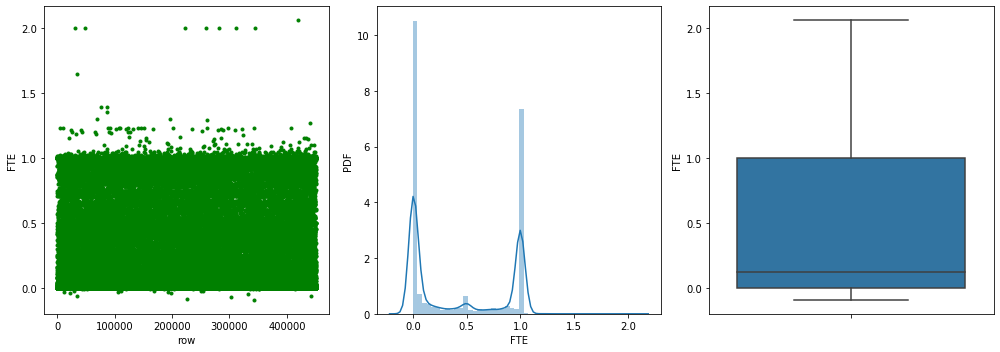

In [32]:
fte_no_outliers = fte[zscores <= 3]
density_plots(fte_no_outliers, 'FTE', outlying=False)

### `Total` univariate analysis

`Total` contains upper and lower outliers with magnitude or +/- 100 millions.

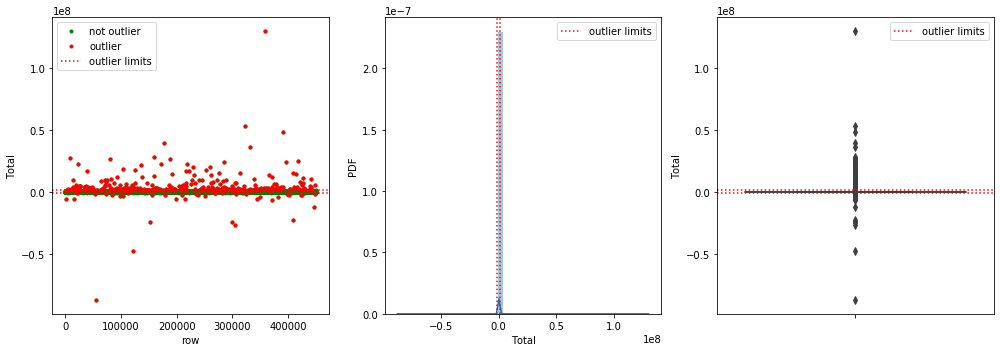

Upper outliers: 317
Lower outliers: 37


In [33]:
total = df.Total.dropna()
density_plots(total, 'Total')
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

Those `Total` outliers are associated with null `FTE`, i.e., they are not related to headcount but to facilities, buildings, insurances, etc.

In [34]:
relevant = ['Total', 'FTE', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[total[(zscores < -3) | (zscores > 3)].index, relevant].sort_values('Total', ascending=False)

,Total,FTE,Fund_Description,Object_Description,Job_Title_Description
358538,1.297000e+08,NaN,General,Payments to a Community School*,NaN
322149,5.323797e+07,NaN,Employee Benefits Self-Insurance,Other Purchased Services,NaN
390959,4.789057e+07,NaN,NaN,PAYMENTS TO ESCROW AGENTS,(blank)
177775,3.956446e+07,NaN,NaN,INTEREST ON LEASES,(blank)
331752,3.645094e+07,NaN,NaN,BUILDINGS,(blank)
...,...,...,...,...,...
152005,-2.399966e+07,NaN,General Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
299589,-2.400000e+07,NaN,Capital Projects Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
304649,-2.646500e+07,NaN,NaN,REDEMPTION OF PRINCIPAL,(blank)
121092,-4.789057e+07,NaN,NaN,PAYMENTS TO ESCROW AGENTS,(blank)


What if to remove all outliers?

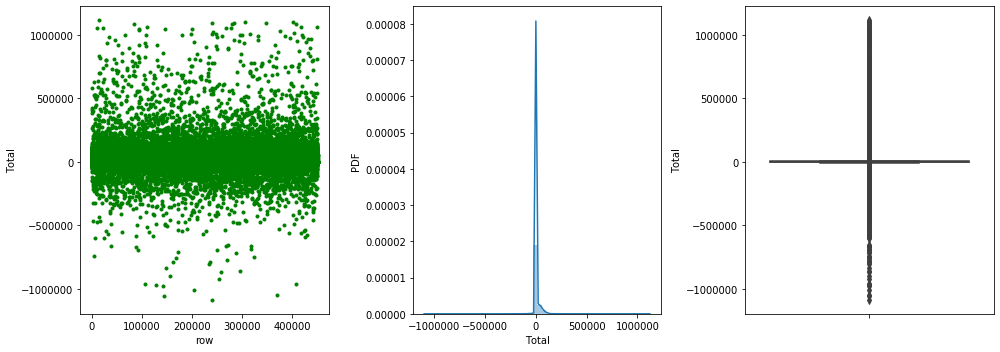

In [35]:
total_no_outliers = total[(zscores >= -3) & (zscores <= 3)]
density_plots(total_no_outliers, 'Total', outlying=False)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

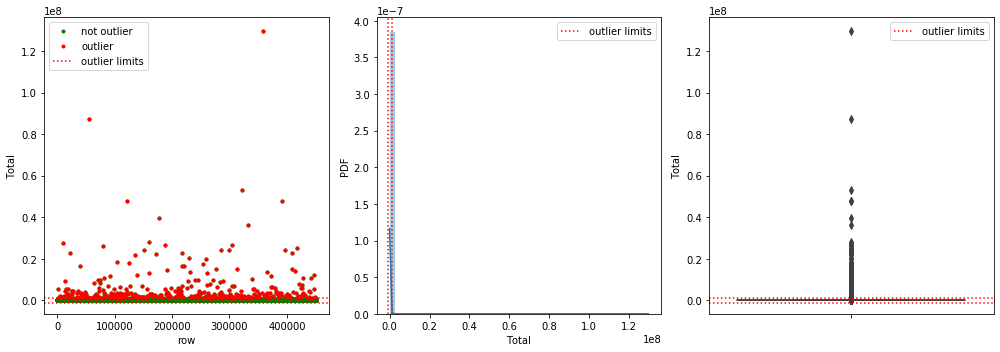

Upper outliers: 352
Lower outliers: 0


In [36]:
total_fixed = total.abs()
density_plots(total_fixed, 'Total')#, outlying=False)
zscores_fixed = zscore(total_fixed)
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### Bivariate analysis

#### Linear regression/correlation by imputation strategy

In [37]:
dropna_df = df[NUMERIC_FEATURES].dropna()
zero_imputed_df = df[NUMERIC_FEATURES].fillna(0)
mean_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].mean())
median_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].median())

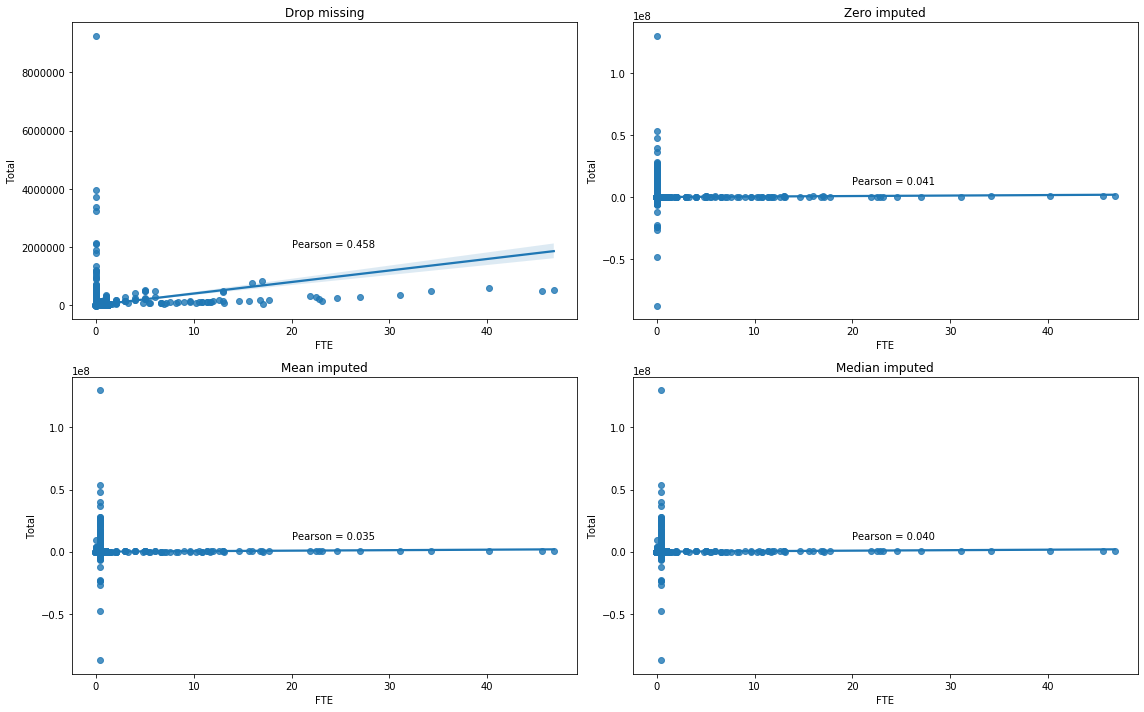

In [38]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
sns.regplot('FTE', 'Total', data=dropna_df)
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(dropna_df.FTE, dropna_df.Total)[0,1]), (20,2000000))
plt.title('Drop missing')
plt.subplot(2,2,2)
sns.regplot('FTE', 'Total', data=zero_imputed_df)
plt.title('Zero imputed')
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(zero_imputed_df.FTE, zero_imputed_df.Total)[0,1]), (20,10000000))
plt.subplot(2,2,3)
sns.regplot('FTE', 'Total', data=mean_imputed_df)
plt.title('Mean imputed')
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(mean_imputed_df.FTE, mean_imputed_df.Total)[0,1]), (20,10000000))
plt.subplot(2,2,4)
sns.regplot('FTE', 'Total', data=mean_imputed_df)
plt.title('Median imputed')
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(median_imputed_df.FTE, median_imputed_df.Total)[0,1]), (20,10000000))
plt.tight_layout()
plt.show()

#### Correlation grouped by `Object_Description`

Correlation grouped by `Object_Description` before and after zero imputation

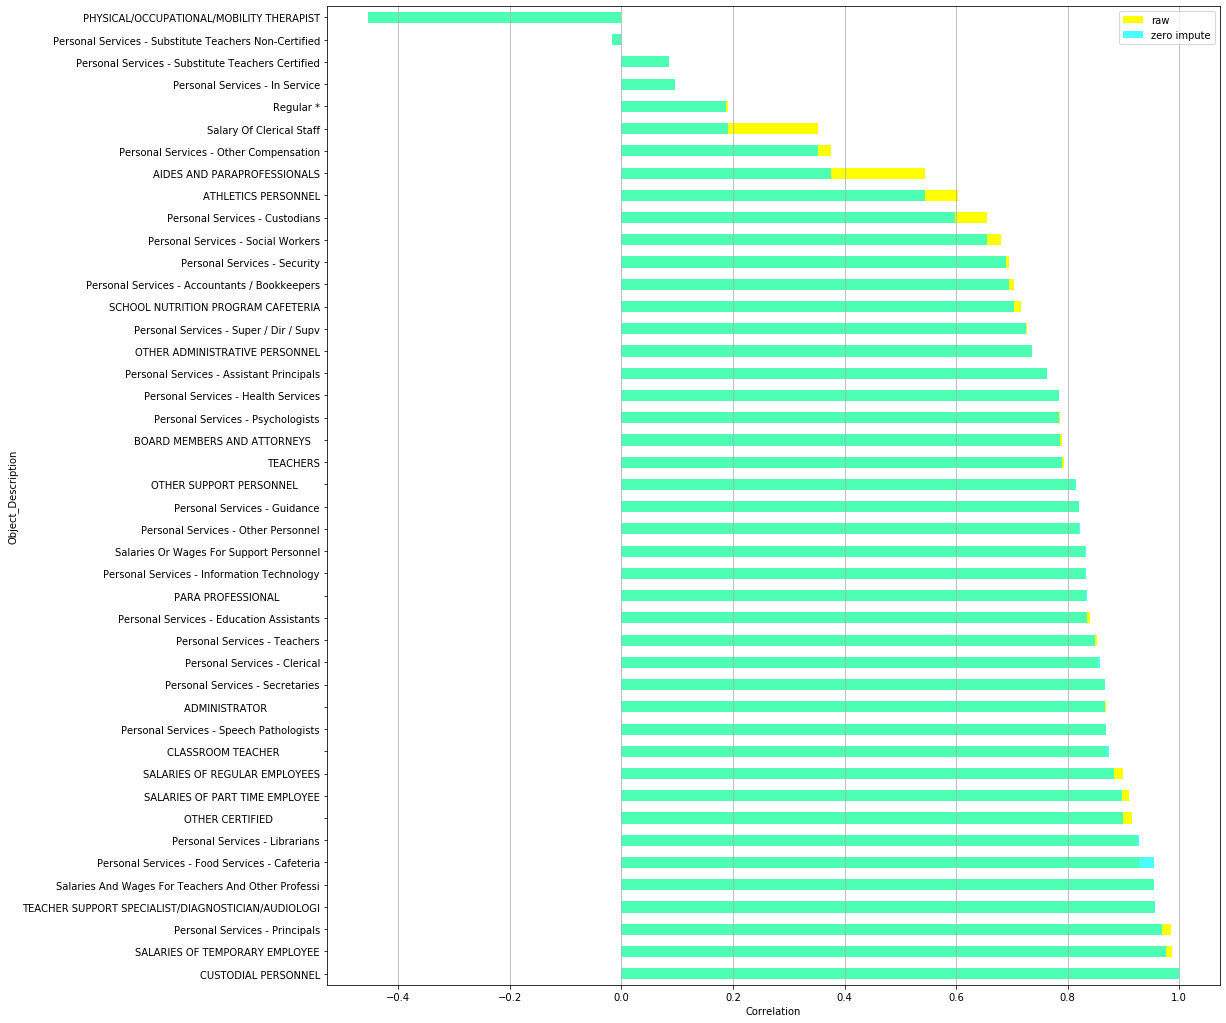

In [39]:
plt.figure(figsize=(16,18))

grouped_corr = df[['Object_Description', 'FTE', 'Total']].groupby('Object_Description').corr()
grouped_corr = grouped_corr.dropna().unstack().iloc[:,2].sort_values(ascending=False)
grouped_corr.plot(kind='barh', label='raw', color='yellow')

imp_zero_corr = df[['Object_Description', 'FTE', 'Total']].copy()
imp_zero_corr['FTE'] = imp_zero_corr.FTE.fillna(0)
imp_zero_corr['Total'] = imp_zero_corr.Total.fillna(0)
plt.xlabel('Correlation')
imp_zero_corr = imp_zero_corr.groupby('Object_Description').corr()
imp_zero_corr = imp_zero_corr.dropna().unstack().iloc[:,2].sort_values(ascending=False)
imp_zero_corr.plot(kind='barh', label='zero impute', color='cyan', alpha=0.7)

plt.grid(axis='x')
plt.legend()
plt.show()

After imputing zero, few variables change their correlation slightly

#### `Total_by_FTE` interaction

In [40]:
bivariate = df[['FTE', 'Total', 'Fund_Description', 'Object_Description', 'Job_Title_Description']].copy()
bivariate['Total_by_FTE'] = bivariate.Total / bivariate.FTE
bivariate = bivariate[['FTE', 'Total', 'Total_by_FTE', 'Fund_Description', 'Object_Description', 'Job_Title_Description']]
bivariate.sort_values('Total_by_FTE', ascending=False)

,FTE,Total,Total_by_FTE,Fund_Description,Object_Description,Job_Title_Description
361674,0.0,153.12000,inf,GENERAL FUND,OTHER PERSONAL SERVICES,SUB TEACHER ALL
11598,0.0,106.74000,inf,General Purpose School,Personal Services - Librarians,NaN
4228,0.0,2789.79000,inf,General Purpose School,Personal Services - Teachers,NaN
172035,0.0,532.94450,inf,GENERAL FUND,OTHER PERSONAL SERVICES,SUBSTITUTE BUS ASSISTANT
11398,0.0,76.50000,inf,GENERAL FUND,OTHER PERSONAL SERVICES,SUB TEACHER ALL
...,...,...,...,...,...,...
307423,NaN,-390.71000,NaN,Miscellaneous State Grants,Other Awards and Prizes,NaN
46691,NaN,283.98864,NaN,NaN,ADDITIONAL/EXTRA DUTY PAY/STIP,"Teacher, Elementary"
109283,NaN,48.62000,NaN,GENERAL FUND,WORKSHOP PARTICIPANT,CURRICULUM RESOURCE TEACHER
433672,NaN,4020.29000,NaN,NaN,EMPLOYEE BENEFITS,Library Technician II


`FTE` filling is inconsistent.  E.g., sometimes zero, others missing.

In [41]:
# Setting all infinite and missing to zero.
#bivariate.loc[np.isinf(bivariate.FTE), 'FTE'] = 0
#bivariate.loc[bivariate.FTE.isnull(), 'FTE'] = 0
#bivariate.loc[np.isinf(bivariate.Total), 'Total'] = 0
#bivariate.loc[bivariate.Total.isnull(), 'Total'] = 0
#bivariate.loc[np.isinf(bivariate.Total_by_FTE), 'Total_by_FTE'] = 0
#bivariate.loc[bivariate.Total_by_FTE.isnull(), 'Total_by_FTE'] = 0
#bivariate.sort_values('Total_by_FTE', ascending=False)

#### Plotting numeric totals grouped by every label

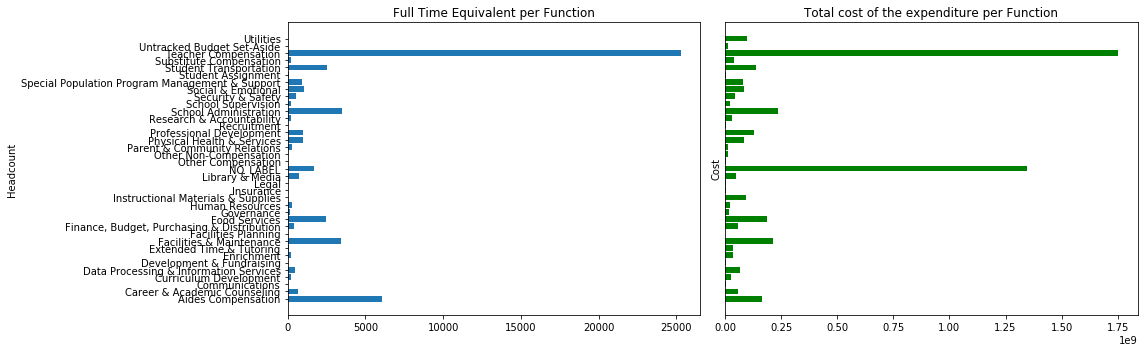

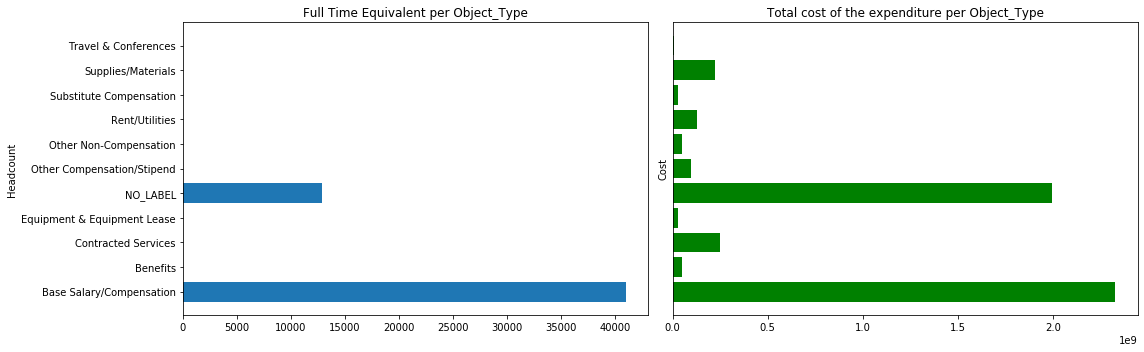

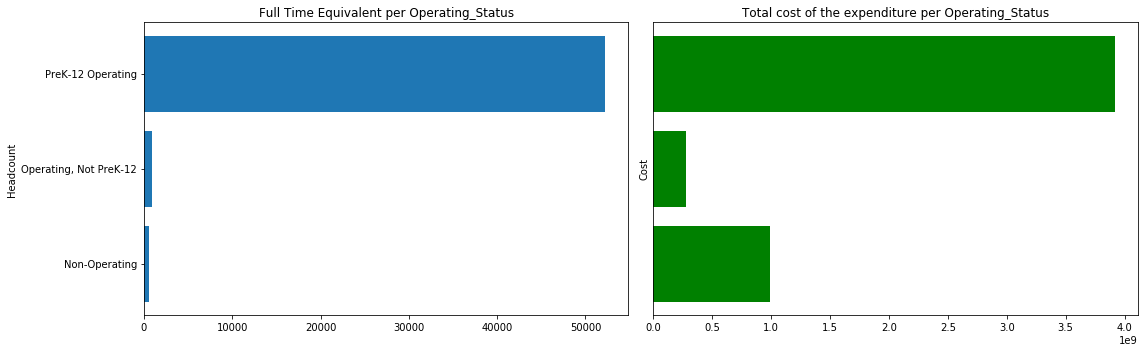

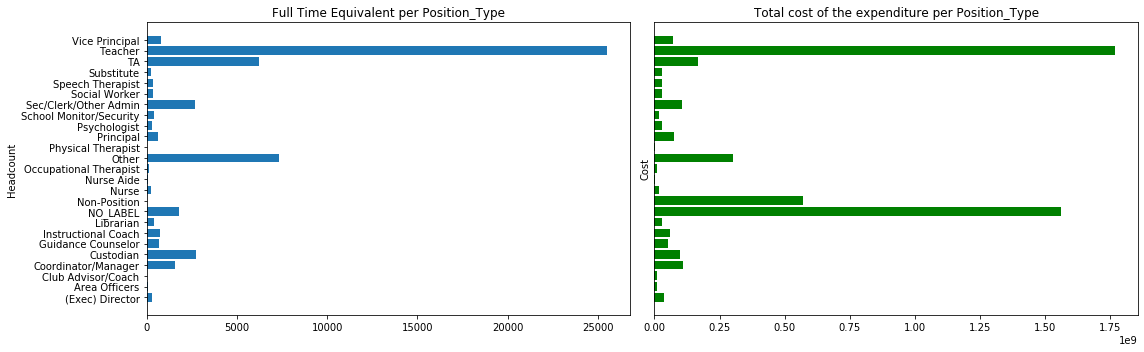

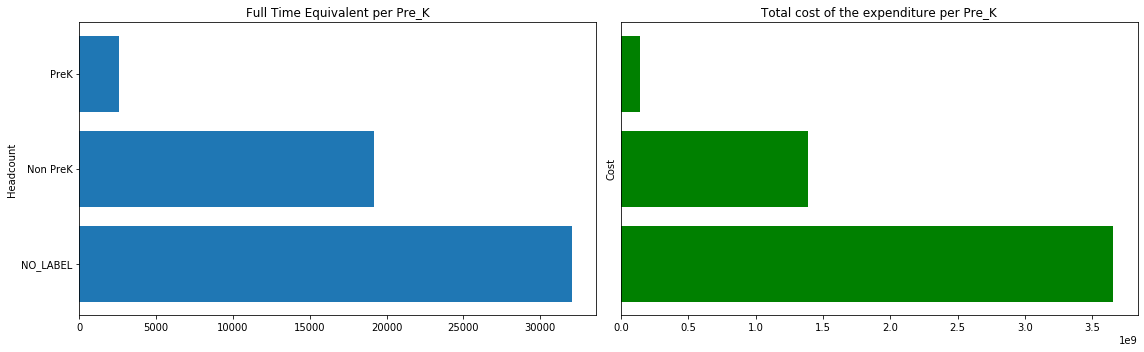

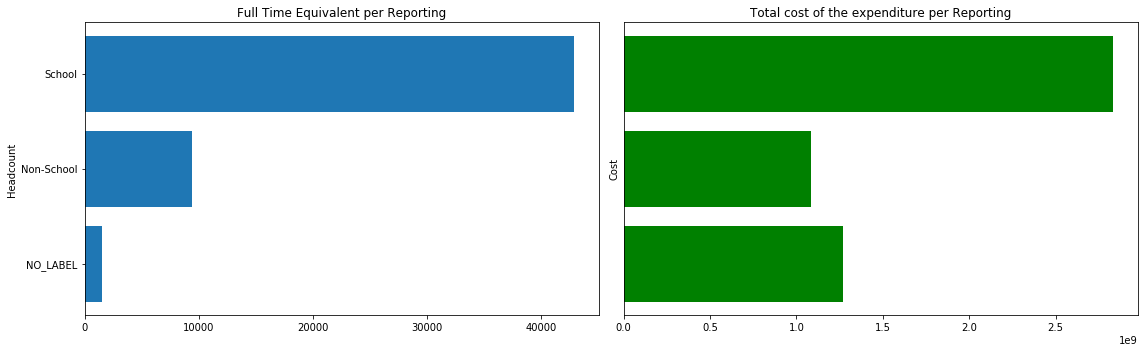

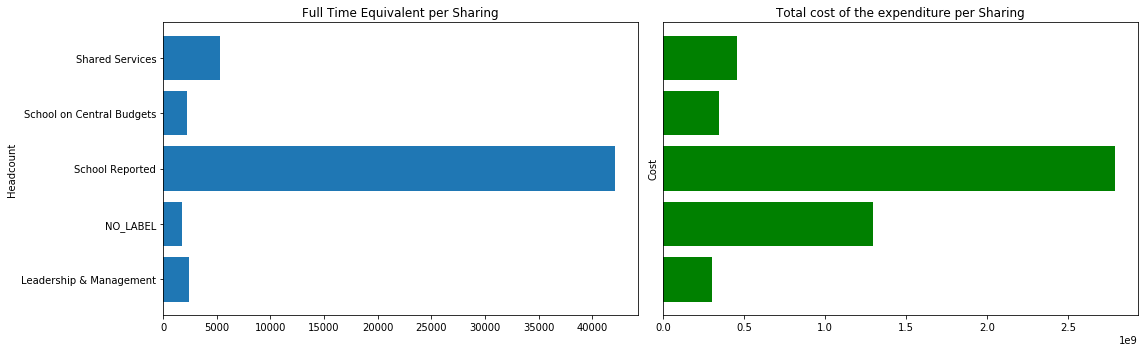

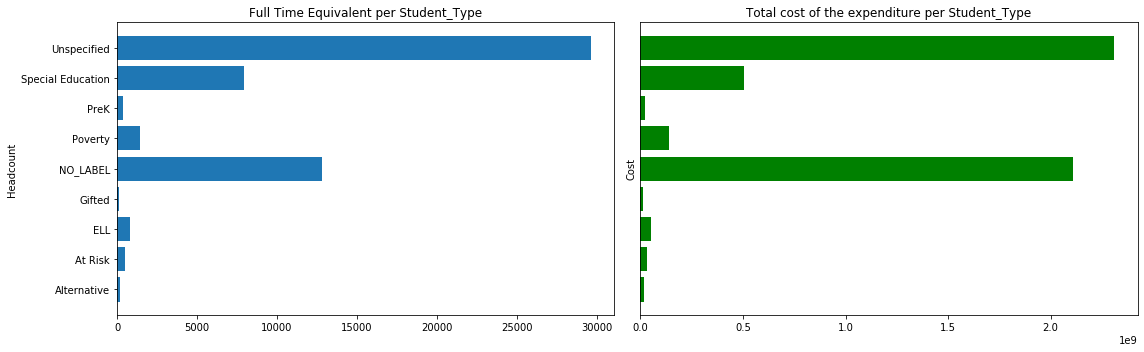

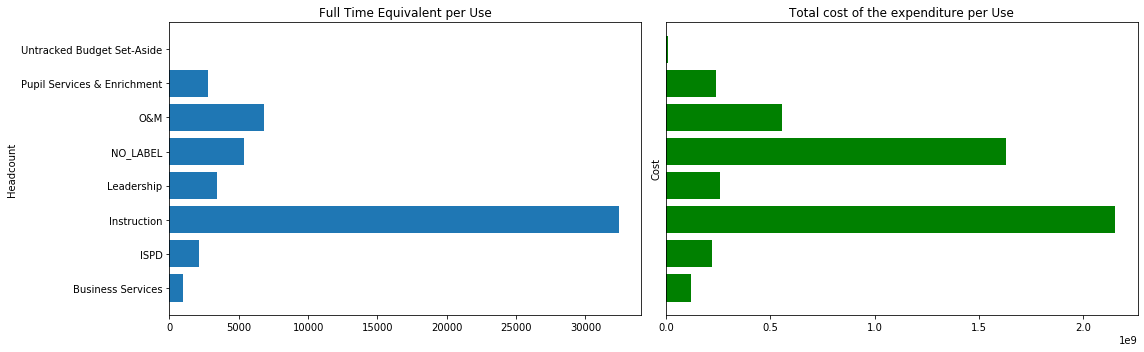

In [42]:
for label in LABELS:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    fte = df.groupby(label).FTE.sum()
    #fte.plot(kind='bar')
    axes[0].barh(fte.index, fte)
    axes[0].set_title('Full Time Equivalent per ' + label)
    axes[0].set_ylabel('Headcount')
    
    total = df.groupby(label).Total.sum()
    #total.plot(kind='bar', color='green')
    axes[1].barh(total.index, total, color='green')
    axes[1].set_title('Total cost of the expenditure per ' + label)
    axes[1].set_ylabel('Cost')
    axes[1].set_yticks([])
    plt.tight_layout()
    plt.show()    

## Free text form variables

Cross value counts helper function

In [43]:
def cross_value_counts(df):
    #cvc = df.replace('(\s+|[^\w+])',' ',regex=True)#.apply(lambda x: x.str.strip())
    cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.upper())
    cvc = cvc.apply(lambda x: x.value_counts(dropna=False)).fillna(0)
    cvc = cvc.apply(pd.to_numeric, downcast='unsigned')
    cvc.index.name = 'text'
    cvc.columns.name = 'columns'
    cvc.index = cvc.index.fillna('NaN')
    decreasing_row_index = cvc.sum(axis=1).sort_values(ascending=False).index
    decreasing_col_index = cvc.sum(axis=0).sort_values(ascending=False).index
    cvc = cvc.loc[decreasing_row_index, decreasing_col_index]
    return cvc

def cross_value_counts_summary(df):

    percent_with_nan = lambda x: x.sum() / (df.shape[0] * df.shape[1]) * 100
    cvc = cross_value_counts(df).replace(0, np.nan)
    cvcs = cvc.agg(['sum', 'count', percent_with_nan], axis='columns')
    cvcs.index.name = 'text'
    cvcs.columns=['Ocurrences', 'Columns', '% w/NaN']

    saved = cvcs.loc['NaN','Ocurrences']
    cvcs.loc['NaN','Ocurrences'] = np.nan
    cvcs['% wo/NaN'] = (cvcs.Ocurrences / cvcs.Ocurrences.sum() * 100).fillna(0)
    cvcs['Cumulated % wo/NaN'] = cvcs['% wo/NaN'].cumsum()
    cvcs.loc['NaN','Ocurrences'] = saved
    cvcs['words'] = cvcs.index.str.split().map(len).tolist()
    
    cvcs = cvcs.apply(pd.to_numeric, downcast='float')
    cvcs = cvcs.apply(pd.to_numeric, downcast='unsigned')

    return cvcs

### Text features frequencies

In [44]:
cross_value_counts(df[TEXT_FEATURES])

columns,Text_1,Fund_Description,Program_Description,Position_Extra,Facility_or_Department,Function_Description,Location_Description,Sub_Object_Description,Text_4,Text_3,Job_Title_Description,SubFund_Description,Text_2,Object_Description
text,,,,,,,,,,,,,,
NaN,107992,197400,95617,135513,346391,58082,238223,308674,346531,291125,107534,93422,312060,24784
GENERAL FUND,0,57212,0,0,0,0,0,0,0,0,0,123327,0,0
EMPLOYEE BENEFITS,32669,0,32669,0,0,54,83,0,0,0,0,0,54,47495
REGULAR,0,0,0,0,0,0,0,0,0,94462,0,0,0,9270
PROFESSIONAL INSTRUCTIONAL,0,0,0,92136,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DIRECTOR ELEM SCHOOL SUPPORT,0,0,0,0,0,0,0,0,0,0,1,0,0,0
EDUCATIONAL AIDE INSTRUC,0,0,0,0,0,0,0,0,0,0,1,0,0,0
TEACHER SPECIALS NEEDS KINDERGARTEN,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Text features frequency summary

In [45]:
df_cvcs = cross_value_counts_summary(df[TEXT_FEATURES])
display(df_cvcs.head(60))

,Ocurrences,Columns,% w/NaN,% wo/NaN,Cumulated % wo/NaN,words
text,,,,,,
NaN,2663348,14,47.526875,0.000000,0.000000,1
GENERAL FUND,180539,2,3.221680,6.139676,6.139676,2
EMPLOYEE BENEFITS,113024,6,2.016889,3.843661,9.983336,2
REGULAR,103732,2,1.851075,3.527663,13.511000,1
PROFESSIONAL INSTRUCTIONAL,92136,1,1.644147,3.133313,16.644312,2
REGULAR INSTRUCTION,78783,4,1.405866,2.679211,19.323523,2
NON PROJECT,76890,1,1.372086,2.614835,21.938358,2
SCHOOL,65524,1,1.169262,2.228306,24.166664,1
UNDESIGNATED,49569,4,0.884548,1.685717,25.852381,1


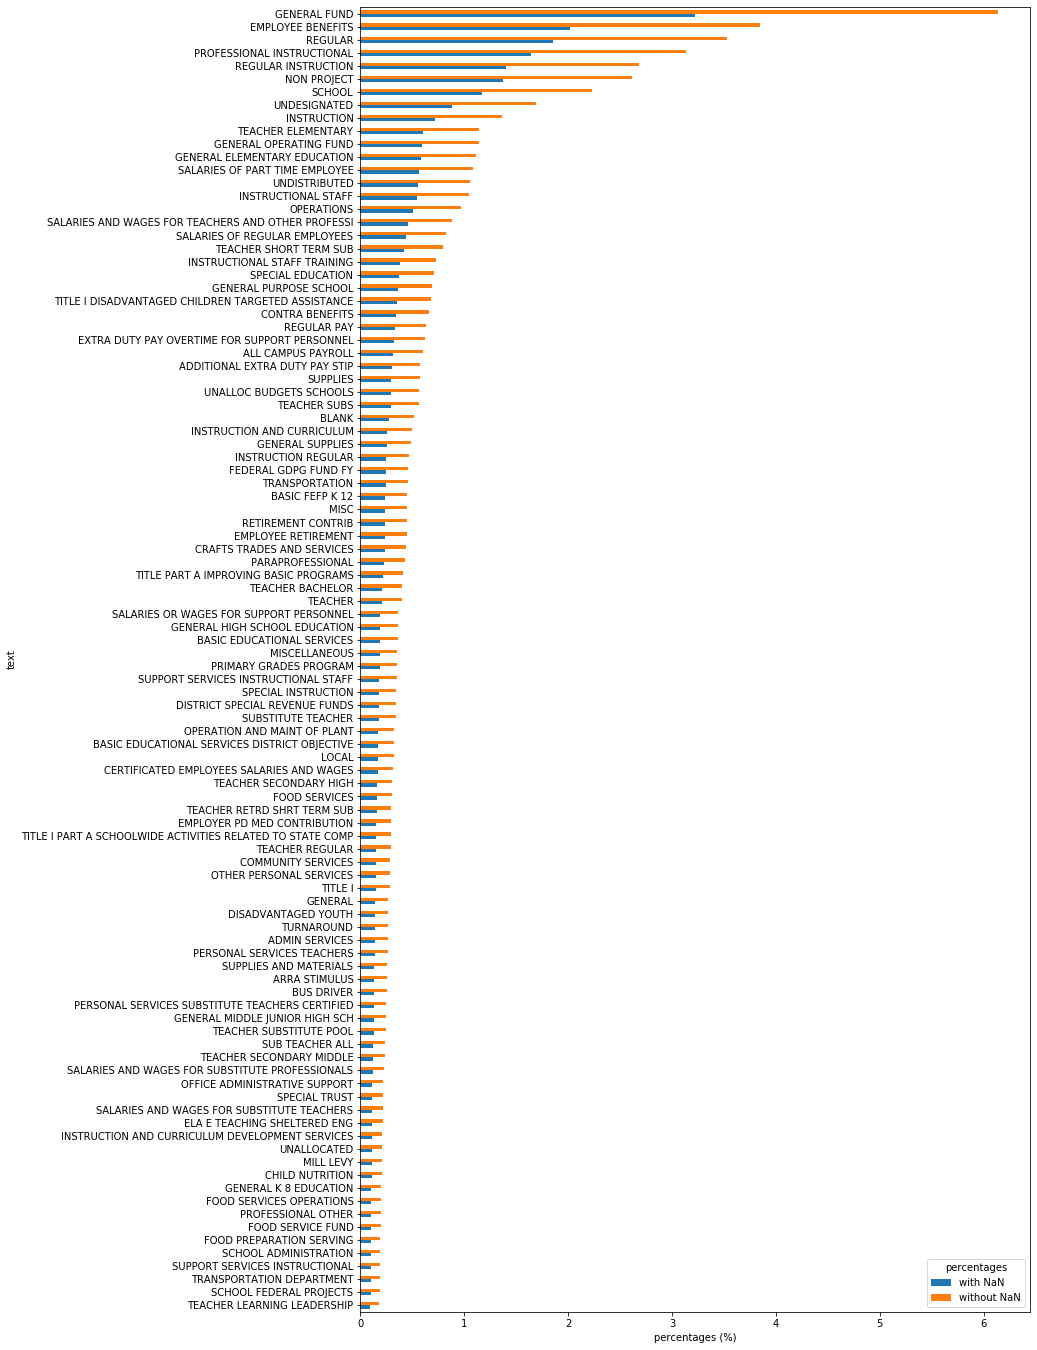

In [46]:
cvcs = pd.concat({'with NaN': df_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': df_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'
cvcs.tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

## Categorical variables

### Unique classes per label

In [47]:
num_unique_labels = df[LABELS].apply(pd.Series.nunique)
print(num_unique_labels)
print('            Total:',num_unique_labels.sum())

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64
            Total: 104


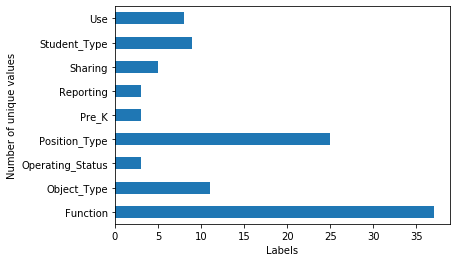

In [48]:
num_unique_labels.plot(kind='barh')
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.show()

### Encoding labels as categories to optimize memory and performance

In [49]:
#Converting label columns to category type
print('Memory before enconding: {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after enconding : {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))

Memory before enconding: 89.4 MB (566.8 MB deep)
Memory after enconding : 65.4 MB (323.6 MB deep)


### Observations per groups of labels

In [ ]:
label_group = pd.DataFrame({'observations':df.groupby(LABELS).size().sort_values()})
label_group

### Groups of labels with less than 2 samples (unstratifiable)

In [ ]:
label_group.loc[label_group.observations < 2,:]

### Converting labels in dummy variables

In [ ]:
# Converting labels in dummy variables
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
dummy_labels

### Class count

In [ ]:
dummy_labels.sum().sort_values()

### Class proportions

In [ ]:
dummy_labels.mean().sort_values()

In [ ]:
dummy_labels.mean().sort_values().plot(kind='barh', figsize=(12,24)); plt.show()

# Exploring holdout data

In [ ]:
holdout=pd.read_csv('../data/TestData.csv', index_col=0, dtype={'Facility_or_Department':'object','Text_4':'object'})
holdout.info()

One can see a random uniform row index sampling in the holdout data overlayed on the training data

In [ ]:
plt.figure(figsize=(16,2))
plt.hist(df.index, bins=4000, histtype='step')
plt.hist(holdout.index, bins=4000, histtype='step')
plt.show()

This holdout dataset has no labels due to the secrecy of the competition, but let's compare de column alignments:

In [ ]:
display(list(zip(FEATURES, holdout.columns.values)))
all(FEATURES == holdout.columns.values)

**Columns between these datasets were not aligned until here.**

In [ ]:
holdout = holdout[FEATURES]
all(FEATURES == holdout.columns.values)

## Missing data **(TODO: replicate df stats)**

Overall count and proportion of missing data compared to training data:

In [ ]:
missing_holdout = holdout.isnull()
pd.DataFrame({'dataset':  ['training', 'holdout'],
              'missing':    [missing.sum().sum(), missing_holdout.sum().sum()],
              'proportion': [missing.sum().sum() / (missing.shape[0] * missing.shape[1]),
                             missing_holdout.sum().sum() / (holdout.shape[0] * holdout.shape[1])]}).set_index('dataset')

**The proportion of missing data in the holdout set is much bigger.**

Comparing missing heatmaps between datasets

In [ ]:
plt.figure(figsize=(16,6))
sns.heatmap(~missing[FEATURES], cbar=False, xticklabels=False)
plt.title('Training set')
plt.figure(figsize=(16,6))
sns.heatmap(~missing_holdout, cbar=False)
plt.title('Holdout set')
plt.show()

Comparing the heatmaps became suspect that the holdout dataset is not just a fair random sample because it's missing data pattern differs a lot from the training dataset.

Next, the columns of both datasets are ordered by the columns of training set with less missing data first. The idea is to compare some sort of missing proportion clusters.

In [ ]:
freq_col_order = missing[FEATURES].sum().sort_values().index.to_list()
plt.figure(figsize=(16,6))
sns.heatmap(~missing[freq_col_order].sort_values(freq_col_order), cbar=False, xticklabels=False)
plt.title('Training set')
plt.figure(figsize=(16,6))
sns.heatmap(~missing_holdout[freq_col_order].sort_values(freq_col_order), cbar=False)
plt.title('Holdout set')
plt.show()

Some missing value areas are proportionally bigger in the holdout set, which is confirmed by the missing ratio which differs a lot.

In [ ]:
(missing_report(holdout)['column proportion'] / missing_report(df[FEATURES])['column proportion']).sort_values(ascending=False)

## FTE

In [ ]:
holdout.FTE.describe()

In [ ]:
fte = holdout.FTE.dropna()
density_plots(fte, 'FTE')
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has only one `FTE` outlier with a value never seen so high in the whole training set: near `11857.24`, while the max `FTE` in training set is `46.8`.

This specific outlier has not textual data.

In [ ]:
holdout[holdout.FTE == holdout.FTE.max()].transpose()

Searching for other observations with no textual data:

In [ ]:
holdout[holdout[TEXT_FEATURES].isnull().all(axis=1)]

There are 116 other observations without textual data.

## Total

In [ ]:
holdout.Total.describe()

In [ ]:
total = holdout.Total.dropna()
density_plots(total, 'Total')
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

In [ ]:
holdout[holdout.Total == holdout.Total.max()].transpose()

## Free text form variables

### Text features frequencies

In [ ]:
cross_value_counts(holdout[TEXT_FEATURES])

### Text features frequency summary

In [ ]:
holdout_cvcs = cross_value_counts_summary(holdout[TEXT_FEATURES])
display(holdout_cvcs)

In [ ]:
cvcs = pd.concat({'with NaN': holdout_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': holdout_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'

cvcs.tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

### Comparing training-holdout text frequency summaries

In [ ]:
cvcs = pd.concat({'train': df_cvcs['% wo/NaN'],
                  'holdout': holdout_cvcs['% wo/NaN']},
                 axis=1, sort=True).fillna(0).sort_values(['train', 'holdout'], ascending=False)
cvcs.index.name='text'
cvcs.columns.name='percentages'
display(cvcs)
cvcs.sort_values(['train', 'holdout']).tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

# Imputation strategy

Text features will be combined, tokenized and counted in different n-gram ranges.

For numeric features:
* Generate a binary indicator for missing `FTE`
* Generate a binary indicator for missing `Total`
* Create a new numeric variable `Total_FTE` with default value `NaN`
* If `FTE` is not null and not zero, then `Total_FTE` = `Total` and `Total` = `NaN`
* Impute zero in remaining missing `FTE`, `Total`, and `Total_FTE`

In [ ]:
from preprocessing.get_normalized_total import get_normalized_total

In [ ]:
df[NUMERIC_FEATURES].info()
df[NUMERIC_FEATURES].head()

In [ ]:
get_normalized_total(df, 'FTE', 'Total').info()
get_normalized_total(df, 'FTE', 'Total').head()

# The log loss

Log loss for binary classification
$$logloss = - \frac{1}{N}\sum^N_{i=1}{(y_i log(p_i) + (1-y_i)log(1-p_i))}$$

>Better to be less confident than confident and wrong

In [ ]:
from metrics.log_loss import log_loss

In [ ]:
print('Wrong and confident       :', log_loss(actual =1, predicted=0))
print('Wrong and not confident   :', log_loss(actual=1, predicted=0.4))
print('Correct and not confident :', log_loss(actual=1, predicted=0.6))
print('Correct and confident     :', log_loss(actual=1, predicted=1))
predicts = np.linspace(0,1,100)
lloss = [log_loss(1,x) for x in predicts]
plt.plot(predicts, lloss, marker='.', linestyle='dotted')
points = [0, 0.4, 0.6, 1]
classes = ['wrong\nconfident', 'wrong\nnot\nconfident', 'correct\nnot\nconfident', 'correct\nconfident']
for i, x in enumerate(points):
    y=log_loss(actual=1, predicted=x)
    plt.plot(x, y, 'ro')
    plt.text(x, y, s=classes[i])
plt.title('Range: {0:} to {1:.2f}'.format(lloss[-1], lloss[0]))
plt.xlabel('predicted')
plt.ylabel('logloss')
plt.show()

 Log loss penalizes highly confident wrong answers much more than any other type. This is a good metric to use in this model and required by the competition.

# The multi-class multi-label log loss

In [ ]:
from metrics.log_loss import multi_multi_log_loss
from dummies import get_dummies_indices
cci = get_dummies_indices(df[LABELS])

# Simple model: only numeric features

In [16]:
from model_selection.multilabel import multilabel_train_test_split

## Setting up a train-test split

* Selecting just numeric features: `df[NUMERIC_FEATURES]`

* Selecting labels as binary variables for multi-label targets: `dummy_labels`

In [18]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NUMERIC_FEATURES], dummy_labels,
                                                               size=0.2, min_count=0, seed=1)

print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
FTE      100992 non-null float64
Total    316574 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Data columns (total 2 columns):
FTE      25079 non-null float64
Total    79148 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 8.6 MB
None


## Allways pre-process after splitting

In [19]:
from sklearn.preprocessing import maxabs_scale

X_train = get_normalized_total(X_train, 'FTE', 'Total')
X_train = X_train.fillna(0)
X_train[:] = maxabs_scale(X_train)

X_test = get_normalized_total(X_test, 'FTE', 'Total')
X_test = X_test.fillna(0)
X_test[:] = maxabs_scale(X_test)

## Training a model

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [47]:
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [48]:
t=time()
clf.fit(X_train, y_train)
print('Elapsed:', time() - t)

Elapsed  74.49479746818542


## Model metrics

In [49]:
print("Training Accuracy:", clf.score(X_train, y_train))
y_pred = clf.predict_proba(X_train)
print("Training Logloss:", multi_multi_log_loss(y_train, y_pred, class_column_indices=cci))
print("Testing Accuracy:", clf.score(X_test, y_test))
y_pred = clf.predict_proba(X_test)
print("Testing Logloss:", multi_multi_log_loss(y_test, y_pred, class_column_indices=cci))
y_pred = clf.predict(X_test)
print("Testing Classification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.046951802187232605
Training Logloss: 1.2950810101292076
Testing Accuracy : 0.04205858472300294
Testing Logloss: 1.32264514619259


C:\Users\mauricio\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3892
           1       0.00      0.00      0.00       604
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00      1472
           4       0.00      0.00      0.00       678
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2152
           7       0.00      0.00      0.00      1652
           8       0.00      0.00      0.00      3969
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       470
          11       1.00      0.00      0.00      2831
          12       0.00      0.00      0.00       141
          13       0.00      0.00      0.00       240
          14       0.00      0.00      0.00      3845
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00       

## Use your model to predict values on holdout data

In [54]:
holdout = pd.read_csv('../data/TestData.csv', index_col=0, dtype={'Facility_or_Department':'object', 'Text_4':'object'})
predictions = clf.predict_proba(maxabs_scale(get_normalized_total(holdout, 'FTE', 'Total').fillna(0)))

## Writing out your results to a csv for submission
At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a .csv using the .to_csv() method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the correct format.

To do this, you'll use your predictions values to create a new DataFrame, prediction_df.

Interpreting LogLoss & Beating the Benchmark:

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

In [55]:
prediction_df = pd.DataFrame(columns=dummy_labels.columns,
                             index=holdout.index,
                             data=predictions)#.apply(lambda x: x.astype('category'), axis=0)
prediction_df.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.036479,0.006524,0.000880,0.024428,0.008816,0.00019,0.032001,0.024356,0.052463,0.000102,...,0.086925,0.519327,0.016250,0.073565,0.441203,0.039028,0.250616,0.114943,0.062655,0.001153
28872,0.036479,0.006524,0.000880,0.024428,0.008816,0.00019,0.032001,0.024356,0.052463,0.000102,...,0.086925,0.519330,0.016250,0.073565,0.441207,0.039028,0.250613,0.114943,0.062655,0.001153
186915,0.071910,0.008212,0.000618,0.008146,0.006180,0.00046,0.016640,0.015075,0.037495,0.000135,...,0.145236,0.696102,0.012959,0.049467,0.694939,0.035580,0.061886,0.112655,0.052348,0.000309
412396,0.071900,0.008213,0.000618,0.008145,0.006180,0.00046,0.016639,0.015075,0.037496,0.000135,...,0.145233,0.696086,0.012959,0.049468,0.694932,0.035582,0.061888,0.112645,0.052350,0.000309
427740,0.071923,0.008212,0.000618,0.008146,0.006180,0.00046,0.016640,0.015076,0.037495,0.000135,...,0.145239,0.696124,0.012959,0.049466,0.694949,0.035576,0.061883,0.112670,0.052346,0.000309


In [56]:
prediction_df.to_csv('/Users/mauricio/Documents/predictions/0.8-numeric-features-logistic-regression-C1.csv')

# Improving your model: NLP

## Combining text features for tokenization

Here all text features are concatenated in each row.

Each row becomes a single document.

In [11]:
from preprocessing.combine_text_columns import combine_text_columns

In [12]:
t=time()
text_vector = combine_text_columns(df, to_drop=NUMERIC_FEATURES + LABELS)
print('Elapsed', time()-t)
text_vector

Elapsed 8.97256851196289


134338       Teacher-Elementary        KINDERGARTEN  KIN...
206341    CONTRACTOR SERVICES BOND EXPENDITURES BUILDING...
326408    Personal Services - Teachers   TCHER 2ND GRADE...
364634    EMPLOYEE BENEFITS TEACHER SUBS GENERAL FUND Te...
47683     TEACHER COVERAGE FOR TEACHER TEACHER SUBS GENE...
                                ...                        
109283    WORKSHOP PARTICIPANT             CURRICULUM RE...
102430    SALARIES OF PART TIME EMPLOYEE  FEDERAL GDPG F...
413949       School Liaison       PARENT/TITLE I Misc Sc...
433672    EMPLOYEE BENEFITS EDUCATIONAL RESOURCE SERVICE...
415831    Salaries And Wages For Substitute Professional...
Length: 400277, dtype: object

In [12]:
print('Memory size {}:', size(sys.getsizeof(text_vector)))

Memory size {}: 89.0 MiB


##  Bag-of-Words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Unigram (word) statistics:

CountVectorizer elapsed time: 9.646817207336426


<400277x3728 sparse matrix of type '<class 'numpy.int64'>'
	with 6290672 stored elements in Compressed Sparse Row format>

,00a,12,1st,2nd,3rd,4th,56,5th,60,60hrs,...,yr,yrbs,yrs,yth,zero,zeta,zone,zoo,zuni,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sparsity                           : 0.9957843892675138
Max term frequency in a document   : 6
Max term frequency in all documents: 331001
Max words in a document            : 49
Mean words per document            : 19.3
Median words per document          : 18.0
Sparse matrix memory usage         : 73.5 MiB
Dense matrix memory equivalence    : 11.1 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5111160,0.812498
1,2,964685,0.153352
2,3,170352,0.027080
3,4,35572,0.005655
4,5,7678,0.001221
5,6,1225,0.000195


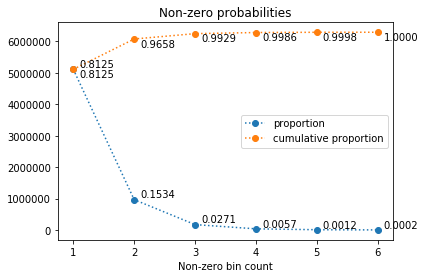

In [25]:
vec = CountVectorizer()
t=time()
tdm = vec.fit_transform(text_vector)
print('CountVectorizer elapsed time:',time()-t)
display(tdm)

display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names()))    

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max term frequency in a document   : {}'.format(tdm.max()))
print('Max term frequency in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max words in a document            : {}'.format(tdm.sum(axis=1).max()))
print('Mean words per document            : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median words per document          : {}'.format(np.median(np.array(tdm.sum(axis=1)))))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*np.int64().itemsize))

print('Non-zero probabilities:',end='')
nz_bin_count = [[bin, (tdm == bin).sum(), (tdm == bin).sum()/tdm.nnz] for bin in range(1, tdm.max() + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))

bin, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.plot(bin, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bin[i]+.1, count[i], '{:.4f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bin, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bin[i]+.1, cumcount[i], '{:.4f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

* **`81%` of the words appear only `1`  time in the rows of the `text_vector`**
* **`99%` of the words appear from `1` to `3` times in the rows of the `text_vector`**

## Tokenizing n-gram ranges

The `CountVectorizer` default `dtype` is `int64`.  As the maximum frequency of any token in a single observation is 6, the 8-bits unsigned integer `uint8` (0 to 255) is enough to store counts of any ngram range.

Iterating over all possible n-gram ranges: `tdm.sum(axis=1).max()`

In [ ]:
print('Initial memory peak: ', size(psutil.Process().memory_info().peak_wset))
msg = 'g{}{} c{} max{}/{} nz{} sparse:{:.2f}% size:{} peak:{} {:.0f}s'
for ngram_range in [(1,x) for x in range(1, tdm.sum(axis=1).max()+1)]:
    t=time()
    vec = CountVectorizer(ngram_range = ngram_range, dtype='uint8')
    tdm = vec.fit_transform(text_vector)
    t=time()-t
    peak_wset = psutil.Process().memory_info().peak_wset
    tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
    tdm_slots = (tdm.shape[0] * tdm.shape[1])
    print(msg.format(ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), tdm.sum(axis=0).max(),
                     tdm.nnz, (1 - tdm.nnz / tdm_slots) * 100, size(tdm_nbytes),
                     size(peak_wset), t))

**Saved results:**  
Initial memory peak:  490.8 MiB  
g11 c3728 max6/331001 nz6290672 sparse:99.58% size:31.5 MiB peak:523.2 MiB 10s  
g12 c32572 max6/331001 nz13167763 sparse:99.90% size:64.3 MiB peak:685.2 MiB 18s  
g13 c91308 max6/331001 nz19888976 sparse:99.95% size:96.4 MiB peak:822.8 MiB 25s  
g14 c181493 max6/331001 nz26296018 sparse:99.96% size:126.9 MiB peak:989.3 MiB 33s  
g15 c304059 max6/331001 nz32351187 sparse:99.97% size:155.8 MiB peak:1.1 GiB 44s  
g16 c457658 max6/331001 nz38050953 sparse:99.98% size:183.0 MiB peak:1.3 GiB 51s  
g17 c639083 max6/331001 nz43383271 sparse:99.98% size:208.4 MiB peak:1.4 GiB 62s  
g18 c843382 max6/331001 nz48343036 sparse:99.99% size:232.0 MiB peak:1.6 GiB 81s  
g19 c1065609 max6/331001 nz52924082 sparse:99.99% size:253.9 MiB peak:1.7 GiB 78s  
g110 c1299651 max6/331001 nz57123587 sparse:99.99% size:273.9 MiB peak:1.9 GiB 89s  
g111 c1538143 max6/331001 nz60946572 sparse:99.99% size:292.1 MiB peak:2.0 GiB 90s  
g112 c1774565 max6/331001 nz64407007 sparse:99.99% size:308.6 MiB peak:2.2 GiB 95s  
g113 c2003991 max6/331001 nz67516090 sparse:99.99% size:323.5 MiB peak:2.3 GiB 103s  
g114 c2222412 max6/331001 nz70289409 sparse:99.99% size:336.7 MiB peak:2.4 GiB 112s  
g115 c2426477 max6/331001 nz72749237 sparse:99.99% size:348.4 MiB peak:2.5 GiB 115s  
g116 c2614225 max6/331001 nz74920467 sparse:99.99% size:358.8 MiB peak:2.6 GiB 123s  
g117 c2784291 max6/331001 nz76826841 sparse:99.99% size:367.9 MiB peak:2.7 GiB 129s  
g118 c2936736 max6/331001 nz78490890 sparse:99.99% size:375.8 MiB peak:2.9 GiB 134s  
g119 c3071856 max6/331001 nz79935242 sparse:99.99% size:382.7 MiB peak:3.0 GiB 134s  
g120 c3190500 max6/331001 nz81185242 sparse:99.99% size:388.6 MiB peak:3.0 GiB 138s  
g121 c3294155 max6/331001 nz82262544 sparse:99.99% size:393.8 MiB peak:3.1 GiB 142s  
g122 c3384554 max6/331001 nz83193456 sparse:99.99% size:398.2 MiB peak:3.1 GiB 148s  
g123 c3463644 max6/331001 nz84002266 sparse:99.99% size:402.1 MiB peak:3.2 GiB 148s  
g124 c3533189 max6/331001 nz84705916 sparse:99.99% size:405.4 MiB peak:3.2 GiB 154s  
g125 c3594644 max6/331001 nz85320470 sparse:99.99% size:408.4 MiB peak:3.3 GiB 145s  
g126 c3649208 max6/331001 nz85859777 sparse:99.99% size:410.9 MiB peak:3.3 GiB 157s  
g127 c3697724 max6/331001 nz86334041 sparse:99.99% size:413.2 MiB peak:3.3 GiB 154s  
g128 c3740841 max6/331001 nz86751560 sparse:99.99% size:415.2 MiB peak:3.4 GiB 159s  
g129 c3779050 max6/331001 nz87119104 sparse:99.99% size:416.9 MiB peak:3.4 GiB 156s  
g130 c3812781 max6/331001 nz87440566 sparse:99.99% size:418.5 MiB peak:3.4 GiB 160s  
g131 c3842324 max6/331001 nz87719094 sparse:99.99% size:419.8 MiB peak:3.4 GiB 341s  
g132 c3867878 max6/331001 nz87956711 sparse:99.99% size:420.9 MiB peak:3.4 GiB 149s  
g133 c3889679 max6/331001 nz88156009 sparse:99.99% size:421.9 MiB peak:3.4 GiB 147s  
g134 c3908002 max6/331001 nz88319906 sparse:99.99% size:422.7 MiB peak:3.5 GiB 155s  
g135 c3923166 max6/331001 nz88451032 sparse:99.99% size:423.3 MiB peak:3.5 GiB 158s  
g136 c3935535 max6/331001 nz88554074 sparse:99.99% size:423.8 MiB peak:3.5 GiB 149s  
g137 c3945420 max6/331001 nz88632711 sparse:99.99% size:424.2 MiB peak:3.5 GiB 147s  
g138 c3953125 max6/331001 nz88691248 sparse:99.99% size:424.4 MiB peak:3.5 GiB 162s  
g139 c3958926 max6/331001 nz88732265 sparse:99.99% size:424.6 MiB peak:3.5 GiB 154s  
g140 c3963114 max6/331001 nz88759772 sparse:99.99% size:424.8 MiB peak:3.5 GiB 153s  
g141 c3966091 max6/331001 nz88779173 sparse:99.99% size:424.9 MiB peak:3.5 GiB 156s  
g142 c3968183 max6/331001 nz88792680 sparse:99.99% size:424.9 MiB peak:3.5 GiB 158s  
g143 c3969642 max6/331001 nz88802396 sparse:99.99% size:425.0 MiB peak:3.5 GiB 156s  
g144 c3970618 max6/331001 nz88808964 sparse:99.99% size:425.0 MiB peak:3.5 GiB 149s  
g145 c3971226 max6/331001 nz88812826 sparse:99.99% size:425.0 MiB peak:3.5 GiB 152s  
g146 c3971537 max6/331001 nz88814674 sparse:99.99% size:425.0 MiB peak:3.5 GiB 150s  
g147 c3971662 max6/331001 nz88815148 sparse:99.99% size:425.0 MiB peak:3.5 GiB 156s  
g148 c3971702 max6/331001 nz88815248 sparse:99.99% size:425.0 MiB peak:3.5 GiB 151s  
g149 c3971712 max6/331001 nz88815268 sparse:99.99% size:425.0 MiB peak:3.5 GiB 154s

## n-gram range frequency plot

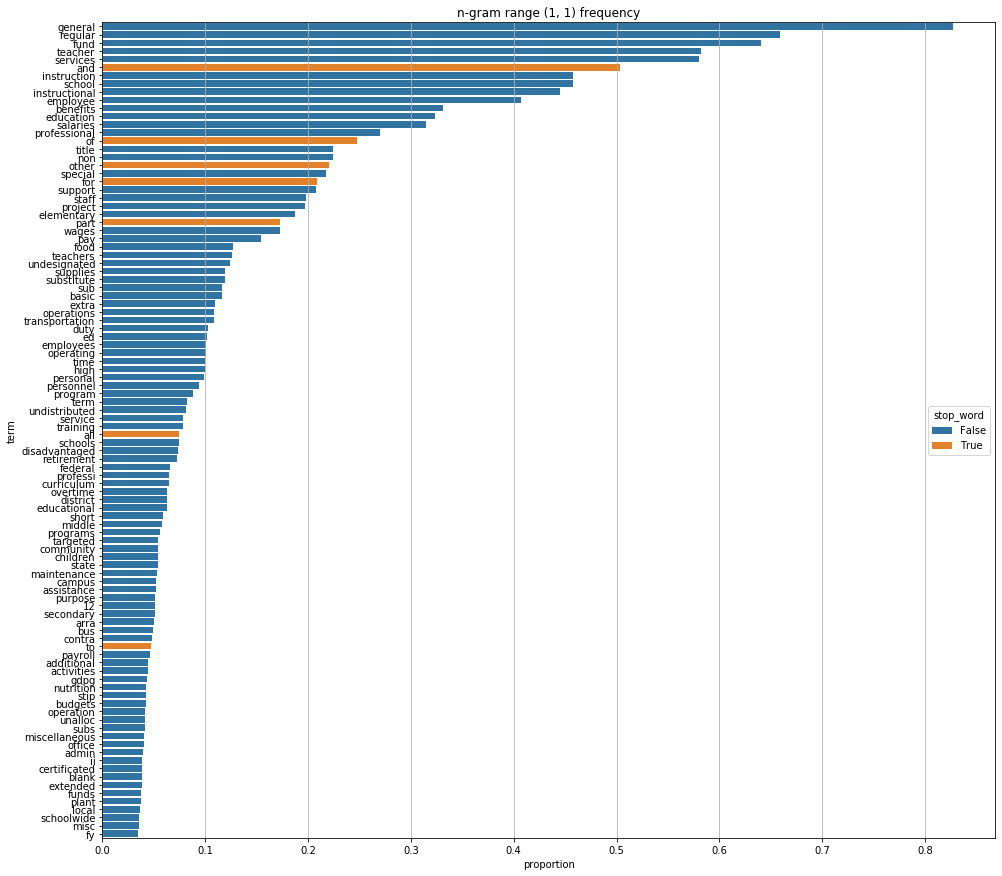

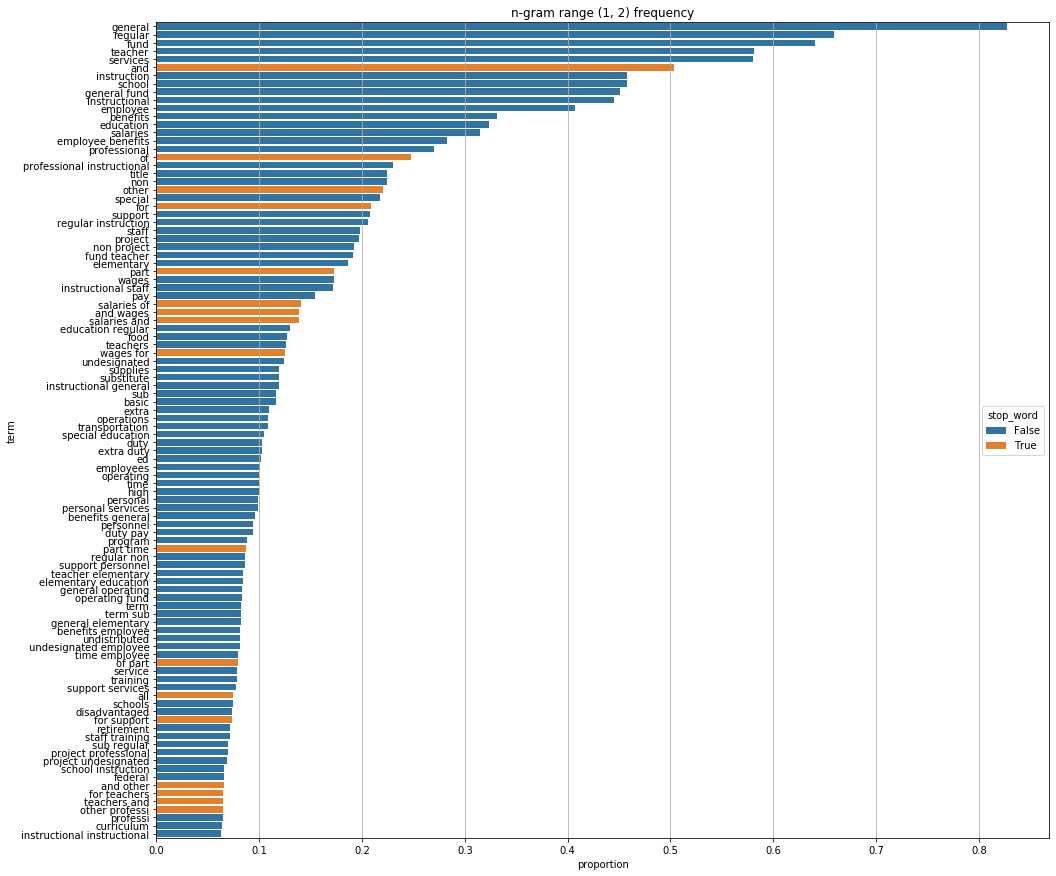

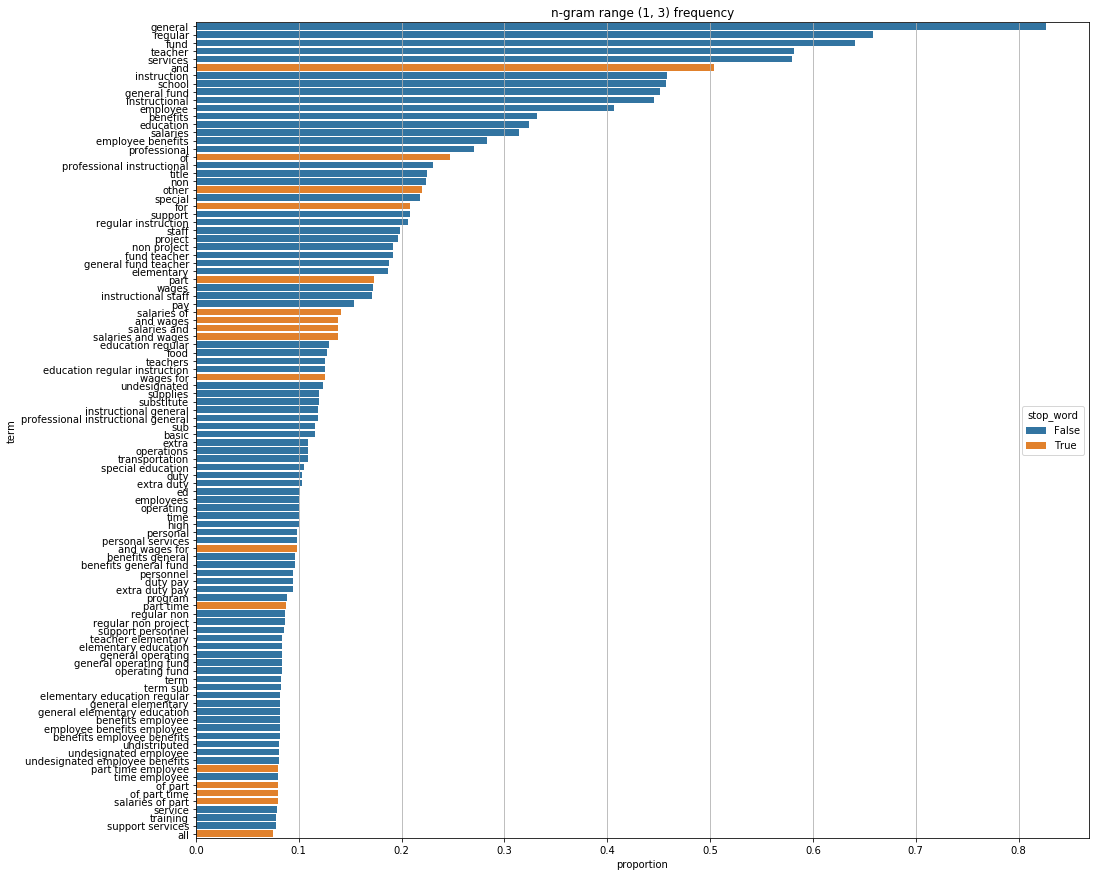

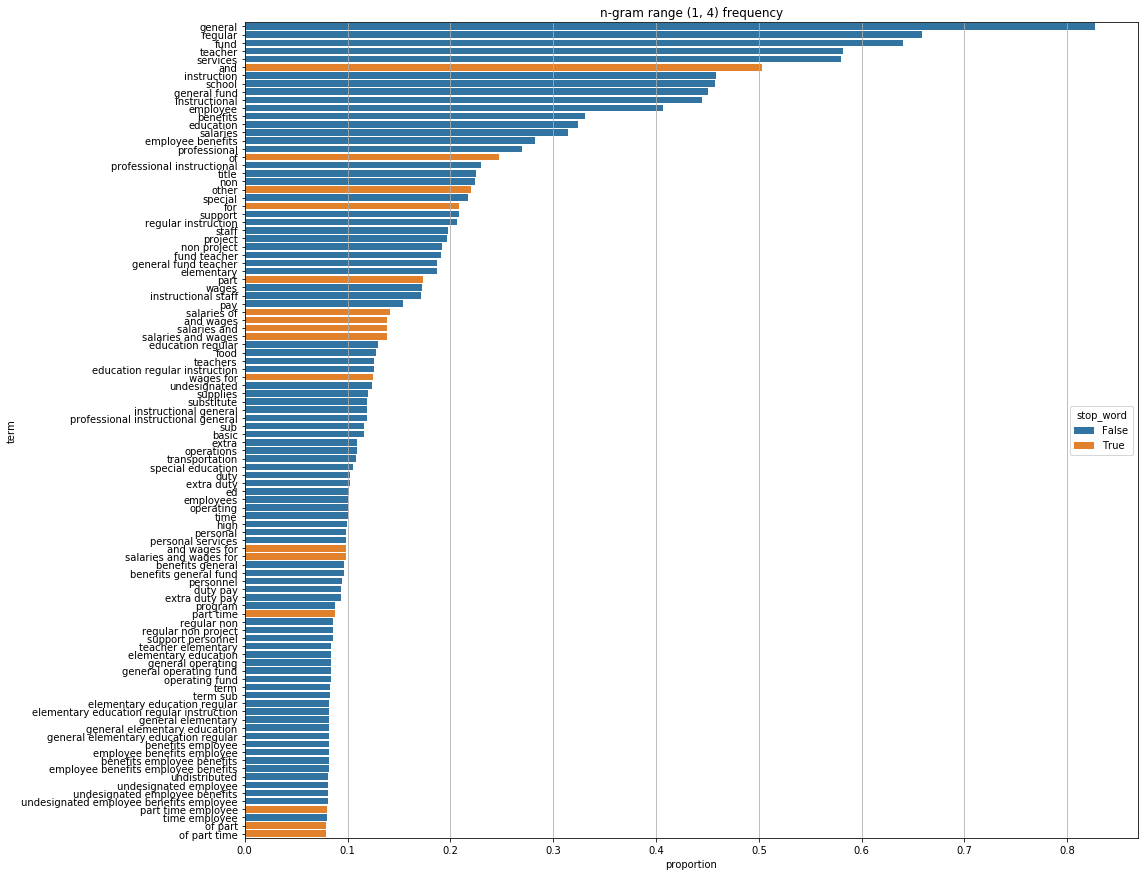

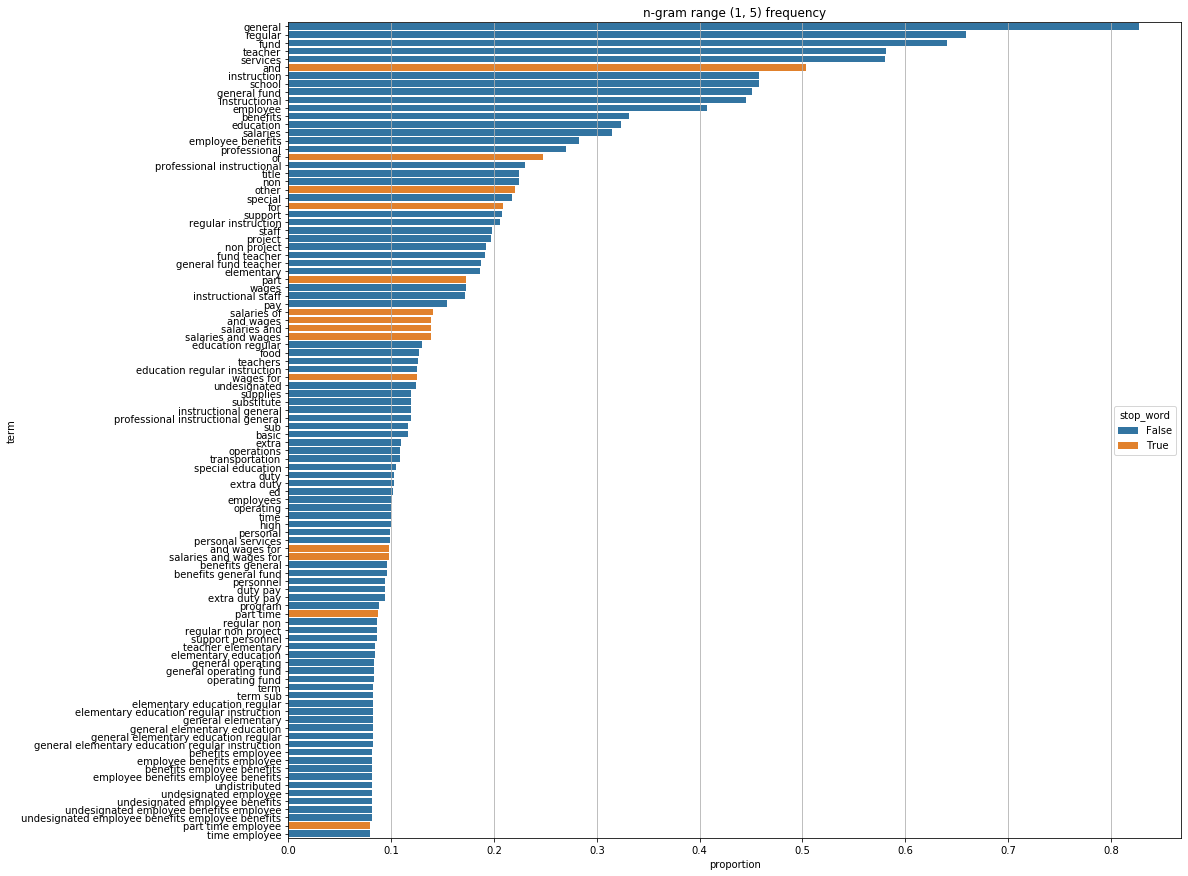

In [13]:
stop_words = CountVectorizer(stop_words='english').get_stop_words()
for ngram_range in [(1,x) for x in range(1,6)]:
    vec = CountVectorizer(dtype='uint8', ngram_range=ngram_range)
    tdm = vec.fit_transform(text_vector)
    term_freq = pd.DataFrame({'term': vec.get_feature_names(),
                              'proportion': tdm.mean(axis=0).tolist()[0],
                              #'stop_word': [True if fn in stop_words else False for fn in vec.get_feature_names()]
                              'stop_word': [True if any([True if word in stop_words else False for word in str.split(words)]) else False for words in vec.get_feature_names()]
                             }).sort_values(['proportion','term'], ascending=(False, True))
    plt.figure(figsize=(16,15))
    plt.grid()
    sns.barplot('proportion', 'term', data=term_freq.head(100), hue='stop_word', dodge=False)
    plt.title('n-gram range {} frequency'.format(ngram_range))
    plt.show()

## Hashing Trick

* Adding new features (e.g. 3-grams, 4-grams) may cause enormous increase in array size
* Hashing is a way of increasing memory efficiency
* Want to make array of features as small as possible: dimensionality Reduction
* Hash functions limits possible outputs, fixing array size
* Particularly useful on large datasets: e.g. lots of text data!

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer

In [14]:
HashingVectorizer()

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=1048576, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

The parameters `norm=None`, `alternate_sign=False` and `binary=False` let us drop in the `HashingVectorizer()` as a replacement for `CounterVectorizer()`

[From sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing):
> Since the hash function might cause collisions between (unrelated) features, a signed hash function is used and the sign of the hash value determines the sign of the value stored in the output matrix for a feature. This way, collisions are likely to cancel out rather than accumulate error, and the expected mean of any output feature’s value is zero. This mechanism is enabled by default with `alternate_sign=True` and is particularly useful for small hash table sizes (`n_features < 10000`). For large hash table sizes, it can be disabled, to allow the output to be passed to estimators like `sklearn.naive_bayes.MultinomialNB` or `sklearn.feature_selection.chi2` feature selectors that expect non-negative inputs.

Why is hashing a useful trick?

A hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

A familiar python datatype, a dictionary, makes this mapping concept a bit more explicit. In fact, python dictionaries ARE hash tables!

`{'petro': 354, 'vend': 785, 'fuel': 895, 'and': 780, 'fluids': 354}`

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

The default limit is `n_features=1048576` $(2^{20})$.  The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).  Enforcing a fixed length can speed up calculations drastically, especially on large datasets!

Tokenizing unigram (words)

HashingVectorizer elapsed time: 30.09520721435547


<400277x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                    : 0.9985012248219768
Max count of a hashed token in a document   : 6.0
Max count of a hashed token in all documents: 331001.0
Max unique hashed tokens per document       : 49.0
Mean unique hashed tokens per document      : 19.3
Median unique tokens per document           : 18.0
Sparse matrix memory usage                  : 73.5 MiB
Dense matrix memory equivalence             : 390.9 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5111160,0.812498
1,2,964685,0.153352
2,3,170352,0.027080
3,4,35572,0.005655
4,5,7678,0.001221
5,6,1225,0.000195


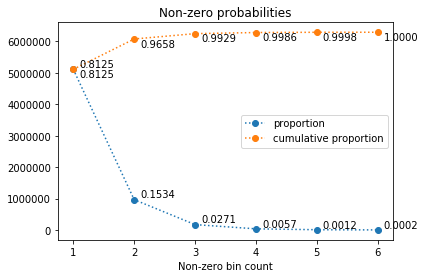

In [16]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False)
t=time()
tdm = vec.fit_transform(text_vector)
print('HashingVectorizer elapsed time:',time()-t)
display(tdm)
print('Sparsity                                    : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1]) * 100))
print('Max count of a hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document       : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document      : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document           : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                  :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence             :', size(tdm.shape[0]*tdm.shape[1]*np.uint8().itemsize))
      
print('Non-zero probabilities:',end='')
nz_bin_count = [[bin, (tdm == bin).sum(), (tdm == bin).sum()/tdm.nnz] for bin in range(1, int(tdm.max()) + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))

bin, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.plot(bin, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bin[i]+.1, count[i], '{:.4f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bin, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bin[i]+.1, cumcount[i], '{:.4f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

The maximum frequency of any hashed 1-gram token in a single observation is also 6. The 8-bits unsigned integer `uint8` (0 to 255) should be enough to store counts of any ngram range as long as there are sufficient `n_features`.

The hashed data, actually the non-zero values of the sparse matrix:

In [22]:
hashed_df = pd.DataFrame(tdm.data, columns=['hash_value'])
hashed_df

,hash_value
0,1.0
1,2.0
2,1.0
3,1.0
4,1.0
...,...
6290667,1.0
6290668,1.0
6290669,1.0
6290670,1.0


Evaluating the hashing collisions

In [23]:
hash_collisions = hashed_df.groupby('hash_value').size()
hash_collisions = pd.DataFrame({'collisions': hash_collisions, 'percent': (hash_collisions / hashed_df.shape[0])})
hash_collisions.sort_values('percent', ascending=False)

,collisions,percent
hash_value,,
1.0,5111160,0.812498
2.0,964685,0.153352
3.0,170352,0.027080
4.0,35572,0.005655
5.0,7678,0.001221
6.0,1225,0.000195


## Tokenizing hashed n-gram ranges

Iterating over `n_features` from the minimum $2^{0}$ to the maximum $2^{30}$ ([Murmurhash3 32-bit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)) and n-gram range from 1 to 3 in order to understand hashing collisions and memory usage.

In [ ]:
print('Initial memory peak: ', size(psutil.Process().memory_info().peak_wset))
msg = '^{} g{}{} c{} h{} max{:.0f}/{:.0f} nz{}:{:.2f}% sz{} pk{} {:.0f}s'
for i in range(0, 31):
    for ngram_range in [(1,1), (1,2), (1,3)]:
        t=time()
        vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, 
                                ngram_range=ngram_range, n_features=2**i, dtype='uint8')
        tdm = vec.fit_transform(text_vector)
        t=time()-t
        peak_wset = psutil.Process().memory_info().peak_wset
        _, hash_counts = np.unique(tdm.data, return_counts=True)
        tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
        tdm_slots = (tdm.shape[0] * tdm.shape[1])
        print(msg.format(i, ngram_range[0], ngram_range[1], tdm.shape[1], len(hash_counts), tdm.max(),
                         tdm.sum(axis=0).max(), tdm.nnz, (1 - tdm.nnz / tdm_slots) * 100,
                         size(tdm_nbytes), size(peak_wset), t))
        #print(list(hash_counts/hash_counts.sum()),'\n')

**Saved results:**  
Initial memory peak:  410.6 MiB  
^0 g11 c1 h49 max49/7739614 nz398403:0.47% sz6.1 MiB pk442.4 MiB 8s  
^0 g12 c1 h49 max97/15080825 nz398403:0.47% sz6.1 MiB pk561.4 MiB 14s  
^0 g13 c1 h49 max144/22023673 nz398403:0.47% sz6.1 MiB pk786.0 MiB 19s  
^1 g11 c2 h35 max36/4187508 nz794417:0.77% sz10.6 MiB pk786.0 MiB 8s  
^1 g12 c2 h58 max58/7827178 nz796765:0.47% sz10.6 MiB pk786.0 MiB 14s  
^1 g13 c2 h85 max87/11209240 nz796765:0.47% sz10.6 MiB pk790.6 MiB 19s  
^2 g11 c4 h26 max26/2453094 nz1549832:3.20% sz19.3 MiB pk790.6 MiB 8s  
^2 g12 c4 h35 max35/4190569 nz1587887:0.83% sz19.7 MiB pk790.6 MiB 15s  
^2 g13 c4 h54 max54/5784679 nz1592212:0.56% sz19.7 MiB pk799.6 MiB 19s  
^3 g11 c8 h17 max18/1325263 nz2702208:15.61% sz32.5 MiB pk799.6 MiB 8s  
^3 g12 c8 h24 max24/2217285 nz3096045:3.32% sz37.0 MiB pk799.6 MiB 14s  
^3 g13 c8 h33 max33/3018322 nz3154089:1.50% sz37.6 MiB pk816.9 MiB 20s  
^4 g11 c16 h14 max15/1034314 nz3921702:38.77% sz46.4 MiB pk816.9 MiB 8s  
^4 g12 c16 h19 max19/1496823 nz5335050:16.70% sz62.6 MiB pk816.9 MiB 14s  
^4 g13 c16 h23 max23/1890535 nz5829836:8.97% sz68.2 MiB pk842.5 MiB 20s  
^5 g11 c32 h11 max11/633333 nz5022569:60.79% sz59.0 MiB pk842.5 MiB 8s  
^5 g12 c32 h14 max14/858706 nz7929966:38.09% sz92.3 MiB pk842.5 MiB 14s  
^5 g13 c32 h17 max17/1113927 nz9553383:25.42% sz110.9 MiB pk900.0 MiB 21s  
^6 g11 c64 h8 max8/418134 nz5619666:78.06% sz65.8 MiB pk900.0 MiB 8s  
^6 g12 c64 h12 max12/502469 nz10123894:60.48% sz117.4 MiB pk900.0 MiB 14s  
^6 g13 c64 h13 max13/641202 nz13405271:47.67% sz154.9 MiB pk967.0 MiB 20s  
^7 g11 c128 h8 max8/358296 nz5955794:88.38% sz69.7 MiB pk967.0 MiB 8s  
^7 g12 c128 h11 max11/406431 nz11450345:77.65% sz132.6 MiB pk967.0 MiB 14s  
^7 g13 c128 h11 max11/533865 nz16092500:68.59% sz185.7 MiB pk981.0 MiB 21s  
^8 g11 c256 h7 max7/352774 nz6142401:94.01% sz71.8 MiB pk981.0 MiB 8s  
^8 g12 c256 h10 max10/358975 nz12368980:87.93% sz143.1 MiB pk981.0 MiB 15s  
^8 g13 c256 h10 max10/450143 nz17932462:82.50% sz206.7 MiB pk981.0 MiB 20s  
^9 g11 c512 h6 max6/339288 nz6222740:96.96% sz72.7 MiB pk981.0 MiB 8s  
^9 g12 c512 h9 max9/342549 nz12712194:93.80% sz147.0 MiB pk981.0 MiB 15s  
^9 g13 c512 h9 max9/350521 nz18849729:90.80% sz217.2 MiB pk981.0 MiB 20s  
^10 g11 c1024 h6 max6/331003 nz6248202:98.48% sz73.0 MiB pk981.0 MiB 8s  
^10 g12 c1024 h8 max8/332813 nz12931733:96.85% sz149.5 MiB pk981.0 MiB 14s  
^10 g13 c1024 h8 max8/336036 nz19316187:95.29% sz222.6 MiB pk981.0 MiB 20s  
**^11 g11 c2048 h6 max6/331001 nz6275510:99.23% sz73.3 MiB pk981.0 MiB 8s**  
^11 g12 c2048 h8 max8/331441 nz13040209:98.41% sz150.8 MiB pk981.0 MiB 14s  
^11 g13 c2048 h8 max8/332508 nz19629629:97.61% sz226.2 MiB pk981.0 MiB 21s  
**^12 g11 c4096 h6 max6/331001 nz6285658:99.62% sz73.5 MiB pk981.0 MiB 8s**  
^12 g12 c4096 h6 max6/331102 nz13127198:99.20% sz151.8 MiB pk981.0 MiB 14s  
^12 g13 c4096 h6 max6/331628 nz19788689:98.79% sz228.0 MiB pk981.0 MiB 20s  
^13 g11 c8192 h6 max6/331001 nz6287429:99.81% sz73.5 MiB pk981.0 MiB 8s  
^13 g12 c8192 h6 max6/331025 nz13154435:99.60% sz152.1 MiB pk981.0 MiB 14s  
^13 g13 c8192 h6 max6/331294 nz19845205:99.39% sz228.6 MiB pk981.0 MiB 20s  
^14 g11 c16384 h6 max6/331001 nz6288381:99.90% sz73.5 MiB pk981.0 MiB 8s  
^14 g12 c16384 h6 max6/331019 nz13160199:99.80% sz152.1 MiB pk981.0 MiB 15s  
^14 g13 c16384 h6 max6/331022 nz19872390:99.70% sz228.9 MiB pk981.0 MiB 20s  
^15 g11 c32768 h6 max6/331001 nz6288404:99.95% sz73.5 MiB pk981.0 MiB 8s  
^15 g12 c32768 h6 max6/331019 nz13163068:99.90% sz152.2 MiB pk981.0 MiB 15s  
^15 g13 c32768 h6 max6/331019 nz19878845:99.85% sz229.0 MiB pk981.0 MiB 20s  
^16 g11 c65536 h6 max6/331001 nz6290648:99.98% sz73.5 MiB pk981.0 MiB 8s  
^16 g12 c65536 h6 max6/331019 nz13166487:99.95% sz152.2 MiB pk981.0 MiB 14s  
^16 g13 c65536 h6 max6/331019 nz19885933:99.92% sz229.1 MiB pk981.0 MiB 21s  
^17 g11 c131072 h6 max6/331001 nz6290665:99.99% sz73.5 MiB pk981.0 MiB 9s  
^17 g12 c131072 h6 max6/331019 nz13166891:99.97% sz152.2 MiB pk981.0 MiB 14s  
^17 g13 c131072 h6 max6/331019 nz19886655:99.96% sz229.1 MiB pk981.0 MiB 21s  
^18 g11 c262144 h6 max6/331001 nz6290666:99.99% sz73.5 MiB pk981.0 MiB 8s  
^18 g12 c262144 h6 max6/331001 nz13166930:99.99% sz152.2 MiB pk981.0 MiB 15s  
^18 g13 c262144 h6 max6/331001 nz19887537:99.98% sz229.1 MiB pk981.0 MiB 20s  
^19 g11 c524288 h6 max6/331001 nz6290671:100.00% sz73.5 MiB pk981.0 MiB 9s  
^19 g12 c524288 h6 max6/331001 nz13167710:99.99% sz152.2 MiB pk981.0 MiB 15s  
^19 g13 c524288 h6 max6/331001 nz19888512:99.99% sz229.1 MiB pk981.0 MiB 22s  
__^20 g11 c1048576 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk981.0 MiB 9s  
^20 g12 c1048576 h6 max6/331001 nz13167719:100.00% sz152.2 MiB pk981.0 MiB 15s  
^20 g13 c1048576 h6 max6/331001 nz19888542:100.00% sz229.1 MiB pk981.0 MiB 21s__  
^21 g11 c2097152 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk981.0 MiB 9s  
^21 g12 c2097152 h6 max6/331001 nz13167721:100.00% sz152.2 MiB pk981.0 MiB 15s  
^21 g13 c2097152 h6 max6/331001 nz19888922:100.00% sz229.1 MiB pk981.0 MiB 21s  
^22 g11 c4194304 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk981.0 MiB 9s  
^22 g12 c4194304 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk981.0 MiB 15s  
^22 g13 c4194304 h6 max6/331001 nz19888965:100.00% sz229.1 MiB pk981.0 MiB 21s  
^23 g11 c8388608 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk981.0 MiB 8s  
^23 g12 c8388608 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk981.0 MiB 15s  
^23 g13 c8388608 h6 max6/331001 nz19888965:100.00% sz229.1 MiB pk981.0 MiB 22s  
^24 g11 c16777216 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk981.0 MiB 9s  
^24 g12 c16777216 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk981.0 MiB 15s  
^24 g13 c16777216 h6 max6/331001 nz19888966:100.00% sz229.1 MiB pk981.0 MiB 22s  
^25 g11 c33554432 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk981.0 MiB 8s  
^25 g12 c33554432 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk981.0 MiB 15s  
^25 g13 c33554432 h6 max6/331001 nz19888966:100.00% sz229.1 MiB pk1.0 GiB 22s  
^26 g11 c67108864 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk1.2 GiB 9s  
^26 g12 c67108864 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk1.4 GiB 15s  
^26 g13 c67108864 h6 max6/331001 nz19888966:100.00% sz229.1 MiB pk1.5 GiB 21s  
^27 g11 c134217728 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk1.7 GiB 9s  
^27 g12 c134217728 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk2.4 GiB 17s  
^27 g13 c134217728 h6 max6/331001 nz19888966:100.00% sz229.1 MiB pk2.5 GiB 22s  
^28 g11 c268435456 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk2.7 GiB 8s  
^28 g12 c268435456 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk4.4 GiB 15s  
^28 g13 c268435456 h6 max6/331001 nz19888966:100.00% sz229.1 MiB pk4.5 GiB 22s  
^29 g11 c536870912 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk4.7 GiB 8s  
^29 g12 c536870912 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk8.4 GiB 16s  
^29 g13 c536870912 h6 max6/331001 nz19888966:100.00% sz229.1 MiB pk8.5 GiB 20s  
^30 g11 c1073741824 h6 max6/331001 nz6290672:100.00% sz73.5 MiB pk8.7 GiB 9s  
^30 g12 c1073741824 h6 max6/331001 nz13167763:100.00% sz152.2 MiB pk13.3 GiB 22s  
^30 g13 c1073741824 h6 max6/331001 nz19888976:100.00% sz229.1 MiB pk13.3 GiB 24s

As stated in [HashVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html):
> there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

The previous experiment shows that:
* For any n-gram level, the max feature count in any cell as well as the hash count stabilizes from `n_features=2**12` on: `6`
* For any n-gram level, the max feature count in a column stabilizes from `n_features=2**18` on: `331001`.  If considering only `1-gram`, it stablizes from `2**11` on.
* The max hash value of 6 allows to downcast its `dtype` from the default `float64` to `uint8` (0 to 255).
* __The number of non-zero elements (NNZ) for ngram (1,1) stored in the CSR matrix is the same of `CountVectorizer` from `n_features=2**20` on, which by the way is the default `n_features`.__

__In order to preserve the same number of non-zero elements as the  1-gram's `CountVectorizer`, a final hashing could be the default `HashingVectorizer` (`n_features=2**20`) except that the `dtype` paremeter was tuned to `'uint8'` to reduce the memory usage. However as `PolynomialFeatures` currently only outputs float types, by default `float64`, the best possible downcasting is to set `HashingVectorizer(dtype='float32')`__

In [24]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, dtype='uint8')
t=time()
tdm = vec.fit_transform(text_vector)
print('HashingVectorizer elapsed time:',time()-t)
display(tdm)
print('Sparsity                                            : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max count of a unigram hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*np.uint8().itemsize))

HashingVectorizer elapsed time: 9.655317306518555


<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                            : 99.999%
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 49
Mean unique hashed tokens per document              : 19.3
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 31.5 MiB
Dense matrix memory equivalence                     : 390.9 GiB


## Dimension reduction

In [15]:
from sklearn.feature_selection import chi2, SelectKBest

One concern is that, among other memory allocations, the `SelectKBest(chi2).fit_transform()` method needs to allocate an array with shape defined by the `n_features` of the previous step `HashingVectorizer` times the number of target labels `104` times the size of the data type `int32`:

$$n\_features \times 104 \times 4$$

Estimate memory allocation (in MB), just for that array, in scenarios from $2^{11}$ to $2^{30}$ `n_features`:

In [15]:
{'2**{} ({} features)'.format(str(e),str(2**e)) : size(2**e * 104 * np.int32().itemsize) for e in range(11,31)}

{'2**11 (2048 features)': '832.0 KiB',
 '2**12 (4096 features)': '1.6 MiB',
 '2**13 (8192 features)': '3.2 MiB',
 '2**14 (16384 features)': '6.5 MiB',
 '2**15 (32768 features)': '13.0 MiB',
 '2**16 (65536 features)': '26.0 MiB',
 '2**17 (131072 features)': '52.0 MiB',
 '2**18 (262144 features)': '104.0 MiB',
 '2**19 (524288 features)': '208.0 MiB',
 '2**20 (1048576 features)': '416.0 MiB',
 '2**21 (2097152 features)': '832.0 MiB',
 '2**22 (4194304 features)': '1.6 GiB',
 '2**23 (8388608 features)': '3.2 GiB',
 '2**24 (16777216 features)': '6.5 GiB',
 '2**25 (33554432 features)': '13.0 GiB',
 '2**26 (67108864 features)': '26.0 GiB',
 '2**27 (134217728 features)': '52.0 GiB',
 '2**28 (268435456 features)': '104.0 GiB',
 '2**29 (536870912 features)': '208.0 GiB',
 '2**30 (1073741824 features)': '416.0 GiB'}

The next simulation takes a `text_vector` extracted from the whole dataset and performs `HashingVectorizer` and `SelectKBest` under different parameters to understand memory usage behavior.  As current system has 16GB, it's been set a threshold of available memory.

For each `ngram_range`, the `k` parameter log space is padded with the number of columns resulted from the  analog `CountVectorizer`, ensuring that the resulting `nnz` from `HashingVectorizer` won't be reduced for that parameter.

In [22]:
ngrams = 3
ngram_ranges = [(1, ngr) for ngr in range(1, ngrams + 1)]
ngram_k = [len(CountVectorizer(ngram_range=n, dtype='uint8').fit(text_vector).vocabulary_) for n in ngram_ranges]
display(ngram_k)
logspaces = np.logspace(2.5, 3.5, 5).round().astype('int')
display(logspaces)
logspaces = list((np.hstack((logspaces, ngram_k[0])),
                  np.hstack((logspaces, ngram_k[:2])),
                  np.hstack((logspaces, ngram_k))))
logspaces

[3728, 32572, 91308]

array([ 316,  562, 1000, 1778, 3162])

[array([ 316,  562, 1000, 1778, 3162, 3728]),
 array([  316,   562,  1000,  1778,  3162,  3728, 32572]),
 array([  316,   562,  1000,  1778,  3162,  3728, 32572, 91308])]

In [ ]:
threshold = psutil.virtual_memory().available
print('Initial memory peak: ', size(psutil.Process().memory_info().peak_wset))
msg = '^{} g{}{} c{} max{}/{} nz{}:{:.0f}% sz{} k{} max{}/{} nz{}:{:.0f}% sz{} pk{} {:.0f}s'

for i in np.arange(20,21):  # np.arange(11,31):
    for ngram_range in ngram_ranges:
        vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False,
                                ngram_range=ngram_range, n_features=2**i, dtype='uint8')
        tdm = vec.fit_transform(text_vector)
        tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
        tdm_slots = (tdm.shape[0] * tdm.shape[1])
        for k in logspaces[ngram_range[1]-1]:
            if k > 2**i:
                continue
            t=time()
            red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
            t=time()-t
            peak_wset = psutil.Process().memory_info().peak_wset
            red_nbytes = (red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)
            red_slots = (red.shape[0] * red.shape[1])
            print(msg.format(i, ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(),
                             tdm.sum(axis=0).max(), tdm.nnz, (1 - tdm.nnz / tdm_slots) * 100, size(tdm_nbytes),
                             k, red.max(), red.sum(axis=0).max(), red.nnz,
                             (1 - red.nnz / red_slots) * 100, size(red_nbytes), size(peak_wset), t))
            if peak_wset >= threshold:
                print('Threshold reached:', size(threshold))
                break
        else:
            continue  # only executed if the inner loop did NOT break
        break  # only executed if the inner loop DID break
    else:
        continue  # likewise
    break  # likewise

**Saved results:**  
Initial memory peak:  742.0 MiB  
^20 g11 c1048576 max6/331001 nz6290672:100% sz31.5 MiB k316 max6/331001 nz5340744:96% sz27.0 MiB pk2.6 GiB 24s  
^20 g11 c1048576 max6/331001 nz6290672:100% sz31.5 MiB k562 max6/331001 nz5924763:97% sz29.8 MiB pk2.6 GiB 23s  
^20 g11 c1048576 max6/331001 nz6290672:100% sz31.5 MiB k1000 max6/331001 nz6170799:98% sz31.0 MiB pk2.6 GiB 23s  
^20 g11 c1048576 max6/331001 nz6290672:100% sz31.5 MiB k1778 max6/331001 nz6269321:99% sz31.4 MiB pk2.6 GiB 23s  
^20 g11 c1048576 max6/331001 nz6290672:100% sz31.5 MiB k3162 max6/331001 nz6289511:100% sz31.5 MiB pk2.6 GiB 23s  
^20 g11 c1048576 max6/331001 nz6290672:100% sz31.5 MiB k3728 max6/331001 nz6290672:100% sz31.5 MiB pk2.6 GiB 23s  
^20 g12 c1048576 max6/331001 nz13167719:100% sz64.3 MiB k316 max6/331001 nz5887356:95% sz29.6 MiB pk2.6 GiB 23s  
^20 g12 c1048576 max6/331001 nz13167719:100% sz64.3 MiB k562 max6/331001 nz8093073:96% sz40.1 MiB pk2.6 GiB 25s  
^20 g12 c1048576 max6/331001 nz13167719:100% sz64.3 MiB k1000 max6/331001 nz9636878:98% sz47.5 MiB pk2.6 GiB 24s  
^20 g12 c1048576 max6/331001 nz13167719:100% sz64.3 MiB k1778 max6/331001 nz11042774:98% sz54.2 MiB pk2.7 GiB 23s  
^20 g12 c1048576 max6/331001 nz13167719:100% sz64.3 MiB k3162 max6/331001 nz11984433:99% sz58.7 MiB pk2.7 GiB 24s  
^20 g12 c1048576 max6/331001 nz13167719:100% sz64.3 MiB k3728 max6/331001 nz12157044:99% sz59.5 MiB pk2.7 GiB 24s  
^20 g12 c1048576 max6/331001 nz13167719:100% sz64.3 MiB k32572 max6/331001 nz13167719:100% sz64.3 MiB pk2.7 GiB 25s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k316 max6/331001 nz5156171:96% sz26.1 MiB pk2.7 GiB 25s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k562 max6/331001 nz7727351:97% sz38.4 MiB pk2.7 GiB 24s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k1000 max6/331001 nz10781032:97% sz52.9 MiB pk2.7 GiB 25s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k1778 max6/331001 nz13050562:98% sz63.8 MiB pk2.7 GiB 25s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k3162 max6/331001 nz15241412:99% sz74.2 MiB pk2.7 GiB 24s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k3728 max6/331001 nz15783386:99% sz76.8 MiB pk2.7 GiB 24s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k32572 max6/331001 nz19576856:100% sz94.9 MiB pk2.7 GiB 24s  
^20 g13 c1048576 max6/331001 nz19888542:100% sz96.4 MiB k91308 max6/331001 nz19888542:100% sz96.4 MiB pk2.7 GiB 25s

Results show `n_features` is the causer of high memory usage, therefore, `n_features` must not be greater than $2^{22}$.

The `n_features=2**22` (4194304) is the feature space size (number of columns) of the `HashingVectorizer` sparse output matrix.

In a resource usage perspective, it seems interesting that the same feature space of the `HashingVectorizer` could be fully reused after the reduction and interaction steps and for that, `k` should be 2895:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times interactions + 1} -1 }{2}}\Bigg\rceil}$$

In [20]:
int((np.sqrt(8 * 2**22 + 1) - 1)/2)

2895

__In order to preserve the same number of non-zero elements as resulted by `CountVectorizer`, the `k` parameter of `SelectKBest` should be number of columns resulted by `CountVectorizer` for each `ngram_range`__

In [23]:
tdm = CountVectorizer(dtype='uint8').fit_transform(text_vector)
tdm.shape[1], tdm.nnz

(3728, 6290672)

In [28]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, dtype='uint8')
tdm = vec.fit_transform(text_vector)
t=time()
red = SelectKBest(chi2, k='all').fit_transform(tdm, dummy_labels)
print('SelectKBest elapsed time:',time()-t)
display(red)
print('Sparsity                                            : {:.3f}%'.format((1 - red.nnz / (red.shape[0]*red.shape[1])) * 100))
print('Max count of a unigram hashed token in a document   : {}'.format(red.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(red.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(red.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(red.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(red.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(red.shape[0]*red.shape[1]*np.uint8().itemsize))

SelectKBest elapsed time: 23.62879729270935


<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                            : 99.999%
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 49
Mean unique hashed tokens per document              : 19.3
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 31.5 MiB
Dense matrix memory equivalence                     : 390.9 GiB


**Cross-validation and multiprocessing considerations:**

Considering these results and as intended to perform a multi-processed k-fold cross-validation over the complete pipeline, the number of processors times `n_features` must be tunned to fit within the 13GiB or less:

$$ n\_features \times processors \leq 13GiB$$

It's possible that the default `n_features` $2^{20}$ (2.7 GiB) is too much for 4 processors.  In this case, it would be necessary to tune `n_features` and `k`.

Althought `k` hasn't affected memory usage in the current step (`SelectKBest`) it surely will in the step (`PolynomialFeatures`).

## Feature union

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'total':'Total'})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
union = FeatureUnion([
    ('numeric_features', Pipeline([
        ('numeric_selector', get_numeric_data),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    ])),
    ('text_features', Pipeline([
        ('text_selector', get_text_data),
        ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='uint8')),
        ('reduction', SelectKBest(chi2))
    ]))
])

In [ ]:
threshold = psutil.virtual_memory().available
print('Initial memory peak: ', size(psutil.Process().memory_info().peak_wset))
msg = '^{} g{}{} c{} k{} u{} nz{}:{:.0f}% sz{} pk{} {:.0f}s'
for i in np.arange(20,21):
    for ngram_range in [(1,1), (1,2), (1,3)]:
        #for k in (np.logspace(2, 4, 9, dtype='int')).tolist(): # [100, 177, 316, 562, 1000, 1778, 3162, 5623, 10000]
        for k in logspaces[ngram_range[1]-1]:
            if k > 2**i:
                continue
            union.set_params(text_features__vectorizer__ngram_range = ngram_range,
                             text_features__vectorizer__n_features = 2**i,
                             text_features__reduction__k = k)
            t=time()
            tdm = union.fit_transform(df[FEATURES], dummy_labels)
            t=time()-t
            peak_wset = psutil.Process().memory_info().peak_wset
            tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
            tdm_slots = (tdm.shape[0] * tdm.shape[1])
            
            print(msg.format(i, ngram_range[0], ngram_range[1], 2**i,
                             k, tdm.shape[1], tdm.nnz, (1 - tdm.nnz / tdm_slots) * 100, size(tdm_nbytes),
                             size(peak_wset), t))
            if peak_wset >= threshold:
                print('Reached threshold:', size(threshold))
                break
        else:
            continue  # only executed if the inner loop did NOT break
        break  # only executed if the inner loop DID break
    else:
        continue  # likewise
    break  # likewise

**Saved results:**  
Initial memory peak:  738.8 MiB  
^20 g11 c1048576 k316 u321 nz6109914:95% sz48.1 MiB pk2.7 GiB 42s  
^20 g11 c1048576 k562 u567 nz6693933:97% sz52.6 MiB pk2.7 GiB 41s  
^20 g11 c1048576 k1000 u1005 nz6939969:98% sz54.5 MiB pk2.7 GiB 41s  
^20 g11 c1048576 k1778 u1783 nz7038491:99% sz55.2 MiB pk2.7 GiB 42s  
^20 g11 c1048576 k3162 u3167 nz7058681:99% sz55.4 MiB pk2.7 GiB 40s  
^20 g11 c1048576 k3728 u3733 nz7059842:100% sz55.4 MiB pk2.7 GiB 41s  
^20 g12 c1048576 k316 u321 nz6656526:95% sz52.3 MiB pk2.8 GiB 48s  
^20 g12 c1048576 k562 u567 nz8862243:96% sz69.1 MiB pk2.8 GiB 47s  
^20 g12 c1048576 k1000 u1005 nz10406048:97% sz80.9 MiB pk2.8 GiB 47s  
^20 g12 c1048576 k1778 u1783 nz11811944:98% sz91.6 MiB pk2.8 GiB 49s  
^20 g12 c1048576 k3162 u3167 nz12753603:99% sz98.8 MiB pk2.8 GiB 49s  
^20 g12 c1048576 k3728 u3733 nz12926214:99% sz100.1 MiB pk2.8 GiB 51s  
^20 g12 c1048576 k32572 u32577 nz13936889:100% sz107.9 MiB pk2.8 GiB 52s  
^20 g13 c1048576 k316 u321 nz5925341:95% sz46.7 MiB pk2.9 GiB 57s  
^20 g13 c1048576 k562 u567 nz8496521:96% sz66.4 MiB pk2.9 GiB 57s  
^20 g13 c1048576 k1000 u1005 nz11550202:97% sz89.6 MiB pk2.9 GiB 58s  
^20 g13 c1048576 k1778 u1783 nz13819732:98% sz107.0 MiB pk2.9 GiB 56s  
^20 g13 c1048576 k3162 u3167 nz16010582:99% sz123.7 MiB pk2.9 GiB 58s  
^20 g13 c1048576 k3728 u3733 nz16552556:99% sz127.8 MiB pk2.9 GiB 57s  
^20 g13 c1048576 k91308 u91313 nz20657712:100% sz159.1 MiB pk2.9 GiB 58s

`FeatureUnion` haven't increased memory usage significantly more than the previous step `SelectKBest`.

`n_features=2**20` is still the goal and `k` must be assessed in the step `PolynomialFeatures`.

## Adding interaction terms

In [17]:
from sklearn.preprocessing import PolynomialFeatures

* Interaction terms are statistical tools that lets your model express what happens if two features appear together in the same row.
* `degree` tells what polynomial degree of interactions to compute.
* Pipelines with interaction terms take a while to train because the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree. High degrees can cause overfitting.

Trying different number of features: $\beta_1x_1 + \beta_2x_2 + \beta_3(x_1x_2)$

When `interaction_only = True` only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.):

$$interactions = \frac{features \times (features + 1)}{2}$$.

In [17]:
dense_array = np.array([[0,0],[0,1],[1,0],[1,1]])
print('4x2 matrix:\n', dense_array)
print('4x3 interactions:\n', PolynomialFeatures(degree=2,
                                                  interaction_only=True,
                                                  include_bias=False).fit_transform(dense_array))

Dense array:
 [[0 0]
 [0 1]
 [1 0]
 [1 1]]
PolynomialFeatures:
 [[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]


In [16]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(dense_array, dtype='float32')
print(repr(sparse_matrix), '\n', sparse_matrix)

interactor = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interactor.fit(sparse_matrix)
interactions = interactor.transform(sparse_matrix)
print('Feature names:', interactor.get_feature_names(), '\n',
      repr(interactions), '\n', interactions)

<4x2 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format> 
   (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0 
Dense:
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
PolynomialFeatures(degree=2, include_bias=False, interaction_only=True,
                   order='C') 
 Feature names: ['x0', 'x1', 'x0 x1'] 
 <4x3 sparse matrix of type '<class 'numpy.float32'>'
	with 5 stored elements in Compressed Sparse Row format> 
   (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 2)	1.0 
Dense:
 [[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]


Estimating interactions on a feature log space:

In [3]:
['{} features result {:.0f} interactions'.format(x, x*(x+1)/2) for x in np.logspace(2, 4, 9, dtype='int').tolist()]

['100 features result 5050 interactions',
 '177 features result 15753 interactions',
 '316 features result 50086 interactions',
 '562 features result 158203 interactions',
 '1000 features result 500500 interactions',
 '1778 features result 1581531 interactions',
 '3162 features result 5000703 interactions',
 '5623 features result 15811876 interactions',
 '10000 features result 50005000 interactions']

Plotting interactions as a function of the number of features.  The blue lines show the maximum of number of features whose interactions are smaller than the dataset observations, by the formula:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times interactions + 1} -1 }{2}}\Bigg\rceil}$$

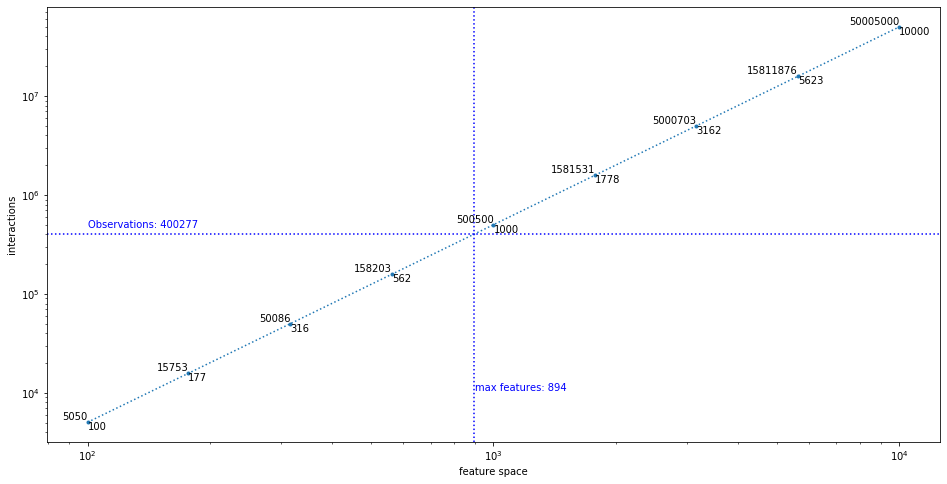

In [14]:
feature_space = np.logspace(2, 4, 9, dtype='int')
interactions = (feature_space * (feature_space + 1) / 2).astype('int64')

plt.figure(figsize=(16,8))
plt.loglog(feature_space, interactions, marker='.', linestyle='dotted')

plt.axhline(df.shape[0], linestyle='dotted', color='blue')
plt.text(x=100, y=df.shape[0]*1.1, s='Observations: {}'.format(df.shape[0]),
         verticalalignment='bottom', color='blue')
max_features = int((np.sqrt(8 * df.shape[0] + 1) - 1) / 2)
plt.axvline(max_features , linestyle='dotted', color='blue')
plt.text(x=max_features*1.01, y=10**4, s='max features: {}'.format(max_features), verticalalignment='bottom', color='blue')
for i,j in zip(feature_space, interactions):
    plt.text(i,j,j, horizontalalignment='right', verticalalignment='bottom')
    plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')
plt.xlabel('feature space')
plt.ylabel('interactions')
plt.show()

## Interacting different hashed n-grams from all text features

The next simulation takes a `text_vector` extracted from the whole dataset and performs `HashingVectorizer`, `SelectKBest` and `PolynomialFeatures` under different parameters to understand memory limitations.  
The current system has 16GB and a threshold of the available memory is set.

For each `ngram_range` a specific parameter space is assigned.  Each space is a log space starting from $2^2.5$ to the limit of the `CountVectorizer` resulting features for a given `ngram_range`

In [24]:
ngram_k = [len(CountVectorizer(ngram_range=(1,n), dtype='uint8').fit(text_vector).vocabulary_) for n in range(1,4)]
ngram_k

[3728, 32572, 91308]

In [42]:
ngram1_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_k[0])), 7).round().astype('int')
ngram1_logspace = np.hstack((ngram1_logspace[ngram1_logspace < ngram_k[0]], ngram_k[0]))
ngram2_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_k[1])), 11).round().astype('int')
ngram2_logspace = np.hstack((ngram2_logspace[ngram2_logspace < ngram_k[1]], ngram_k[1]))
ngram3_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_k[2])), 11).round().astype('int')
ngram3_logspace = np.hstack((ngram3_logspace[ngram3_logspace < ngram_k[2]], ngram_k[2]))
logspaces = list((ngram1_logspace, ngram2_logspace, ngram3_logspace))
logspaces

[array([ 316,  562, 1000, 1778, 3162, 3728]),
 array([  316,   562,  1000,  1778,  3162,  5623, 10000, 17783, 31623,
        32572]),
 array([  316,   562,  1000,  1778,  3162,  5623, 10000, 17783, 31623,
        56234, 91308])]

In [ ]:
print('Initial memory peak: ', size(psutil.Process().memory_info().peak_wset))
threshold = psutil.virtual_memory().available
print('Threshold/Free mem.: ', size(threshold))
msg = '^{}={} g{}{} ' + \
      'k{}u{} nz{}:{:.4f} {} {} {:.0f}s ' + \
      'i{} nz{}:{:.4f} {} {} {:.0f}s'

for i in np.arange(20, 23):
    for ngram_range in [(1,1), (1,2), (1,3)]:
        for k in logspaces[ngram_range[1]-1]:   
            if k > 2**i:
                continue
            union.set_params(text_features__vectorizer__n_features = 2**i,
                             text_features__vectorizer__ngram_range = ngram_range,
                             text_features__reduction__k = k)
            t1=time()
            un = union.fit_transform(df[FEATURES], dummy_labels)
            t1=time()-t1
            un_nbytes = (un.data.nbytes + un.indptr.nbytes + un.indices.nbytes)
            un_peak = psutil.Process().memory_info().peak_wset
            
            t2=time()
            iact = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(un)
            t2=time()-t2
            peak_wset = psutil.Process().memory_info().peak_wset
            iact_nbytes = (iact.data.nbytes + iact.indptr.nbytes + iact.indices.nbytes)
            
            print(msg.format(i, 2**i, ngram_range[0], ngram_range[1],
                             k, un.shape[1], un.nnz, (1-un.nnz/(un.shape[0]*un.shape[1])),
                             size(un_nbytes), size(un_peak), t1,
                             iact.shape[1], iact.nnz, (1-iact.nnz/(iact.shape[0] * iact.shape[1])),
                             size(iact_nbytes), size(peak_wset), t2))

            mem1=psutil.virtual_memory().available
            del un, iact
            mem2=psutil.virtual_memory().available
            print('\t<del> released {} available {}'.format(size(mem2-mem1), size(mem2)))

            if peak_wset >= threshold or mem_delta > mem2:
                print('\tReached threshold: {} available: {}'.format(size(threshold),
                                                                     size(mem2)))
                break
        else:
            continue  # only executed if the inner loop did NOT break
        break  # only executed if the inner loop DID break
    else:
        continue  # likewise
    break  # likewise

**Saved results:**  
Initial memory peak:  744.2 MiB  
Threshold/Free mem.:  13.4 GiB  
^20=1048576 g11 k316u321 nz6109914:0.9524 48.1 MiB 2.6 GiB 42s i51681 nz56116616:0.9973 429.7 MiB 2.6 GiB 3s  
^20=1048576 g11 k562u567 nz6693933:0.9705 52.6 MiB 2.6 GiB 42s i161028 nz65954678:0.9990 504.7 MiB 2.8 GiB 4s  
^20=1048576 g11 k1000u1005 nz6939969:0.9827 54.5 MiB 2.8 GiB 41s i505515 nz70322636:0.9997 538.0 MiB 3.0 GiB 4s  
^20=1048576 g11 k1778u1783 nz7038491:0.9901 55.2 MiB 3.0 GiB 41s i1590436 nz72101374:0.9999 551.6 MiB 3.0 GiB 4s  
^20=1048576 g11 k3162u3167 nz7058681:0.9944 55.4 MiB 3.0 GiB 40s i5016528 nz72460105:1.0000 554.4 MiB 3.1 GiB 4s  
**^20=1048576 g11 k3728u3733 nz7059842:0.9953 55.4 MiB 3.1 GiB 41s i6969511 nz72479455:1.0000 554.5 MiB 3.1 GiB 5s**  
^20=1048576 g12 k316u321 nz6656526:0.9482 52.3 MiB 3.1 GiB 47s i51681 nz73212731:0.9965 560.1 MiB 3.1 GiB 4s  
^20=1048576 g12 k562u567 nz8862243:0.9610 69.1 MiB 3.1 GiB 47s i161028 nz127138113:0.9980 971.5 MiB 5.1 GiB 7s  
^20=1048576 g12 k1000u1005 nz10406048:0.9741 80.9 MiB 5.1 GiB 47s i505515 nz171108479:0.9992 1.3 GiB 6.7 GiB 11s  
^20=1048576 g12 k1778u1783 nz11811944:0.9834 91.6 MiB 6.7 GiB 52s i1590436 nz211619361:0.9997 1.6 GiB 8.2 GiB 14s  
^20=1048576 g12 k3162u3167 nz12753603:0.9899 98.8 MiB 8.2 GiB 50s i5016528 nz241119979:0.9999 1.8 GiB 9.3 GiB 17s  
^20=1048576 g12 k5623u5628 nz13322747:0.9941 103.2 MiB 9.3 GiB 50s i15840006 nz259901287:1.0000 1.9 GiB 10.0 GiB 20s  
^20=1048576 g12 k10000u10005 nz13718410:0.9966 106.2 MiB 10.0 GiB 52s i50055015 nz273400373:1.0000 2.0 GiB 10.5 GiB 23s  
^20=1048576 g12 k17783u17788 nz13883931:0.9981 107.5 MiB 10.5 GiB 50s i158215366 nz279082583:1.0000 2.1 GiB 10.8 GiB 34s  
^20=1048576 g12 k31623u31628 nz13936444:0.9989 107.9 MiB 10.8 GiB 52s i500181006 nz280871385:1.0000 2.1 GiB 10.8 GiB 67s  
**^20=1048576 g12 k32572u32577 nz13936889:0.9989 107.9 MiB 10.8 GiB 50s i530646753 nz280886208:1.0000 2.1 GiB 10.8 GiB 72s**  
^20=1048576 g13 k316u321 nz5925341:0.9539 46.7 MiB 10.8 GiB 57s i51681 nz63378767:0.9969 485.1 MiB 10.8 GiB 3s  
^20=1048576 g13 k562u567 nz8496521:0.9626 66.4 MiB 10.8 GiB 56s i161028 nz127797664:0.9980 976.5 MiB 10.8 GiB 7s  
^20=1048576 g13 k1000u1005 nz11550202:0.9713 89.6 MiB 10.8 GiB 56s i505515 nz229482412:0.9989 1.7 GiB 10.8 GiB 14s  
^20=1048576 g13 k1778u1783 nz13819732:0.9806 107.0 MiB 10.8 GiB 58s i1590436 nz318995602:0.9995 2.4 GiB 12.2 GiB 23s  
**^20=1048576 g13 k3162u3167 nz16010582:0.9874 123.7 MiB 12.2 GiB 57s i5016528 nz404813138:0.9998 3.0 GiB 13.4 GiB 751s**  
	Reached threshold: 13.4 GiB available: 13.8 GiB

**The memory threshold is reached when `ngram_range=(1,3)` and `k=3162`.**

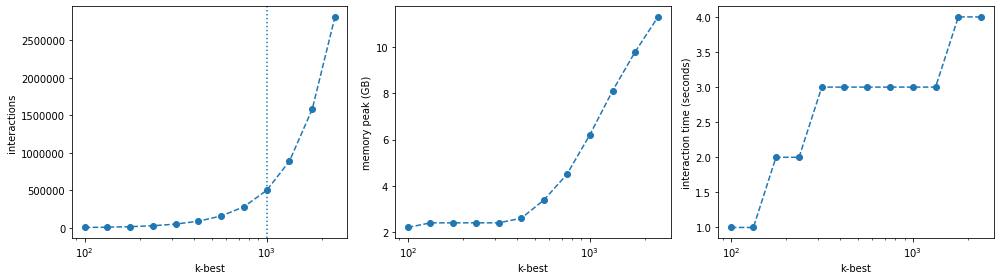

In [29]:
k = (np.logspace(2, 3.5, 13, dtype='int'))[:-1]
# [100,133,177,237,316,421,562,749,1000,1333,1778,2371]
i = (k * (k + 1) / 2).astype('int64')
p = [2.2, 2.4, 2.4, 2.4, 2.4, 2.6, 3.4, 4.5, 6.2, 8.1, 9.8, 11.3]
t = [1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.semilogx(k, i, 'o--')
plt.axvline(x=10**3, linestyle='dotted')
plt.xlabel('k-best')
plt.ylabel('interactions')

plt.subplot(1,3,2)
plt.semilogx(k, p, 'o--')
plt.xlabel('k-best')
plt.ylabel('memory peak (GB)')

plt.subplot(1,3,3)
plt.semilogx(k, t, 'o--')
plt.xlabel('k-best')
plt.ylabel('interaction time (seconds)')
plt.tight_layout()
plt.show()

## Feature scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), also known as data normalization, is a method used to normalize the range of independent variables or features of data.

See [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

One can use different **scalers, transformers, and normalizers** to bring the data within a pre-defined range.

Scalers are **linear transformers** (more precisely [affine transformers](https://en.wikipedia.org/wiki/Affine_transformation)) and differ from each other in the way to estimate the parameters used to shift and scale **each feature**:
* `StandardScaler` - standardizes features by removing the mean and scaling to unit variance
* `MinMaxScaler` - transforms features by scaling each feature to a given range, default (0, 1)
* `MaxAbsScaler` - scales each feature by its maximum absolute value to a range (-1, 1)
* `RobustScaler` - scales features using statistics that are robust to outliers

Transformers provides non-linear transformations:
* `QuantileTransformer` - transforms features using quantiles information, where distances between marginal outliers and inliers are shrunk.
* `PowerTransformer` - applies a power transform featurewise to make data more Gaussian-like, where data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a **per sample** transformation instead of a **per feature** transformation:
* `Normalizer` - normalizes samples individually to unit norm
> Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

Initial considerations:
* As `StandardScaler`, `MinMaxScaler` is very sensitive to the presence of outliers.
* On positive only data, `MaxAbsScaler` behaves similarly to MinMaxScaler, suffering from the presence of large outliers.
* The centering and scaling statistics of the `RobustScaler` are based on percentiles and not influenced by a few number of very large marginal outliers. The resulting range of the transformed feature values is larger than for the previous scalers and are approximately similar.
* `PowerTransformer(method='Yeo-Johnson')` can be applied to both negative and positive data.
* `PowerTransformer(method='Box-Cox')` can only be applied to strictly positive data.
* `QuantileTransformer(output_distribution='gaussian')`: Note that this non-parametetric transformer introduces saturation artifacts for outliers.
* `QuantileTransformer(output_distribution='uniform')` as `RobustScaler`, are robust to outliers but they will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

Final considerations:

For this problem, we need to scale a sparse matrix without destroying any sparsity, i.e., non-stored zero values should continue being like that.  The scalers/settings supporting that are:
* `StandardScaler(with_mean=False)`
* `MaxAbsScaler`
* `RobustScaler(with_centering=False)`
* `Normalizer(norm='l2')`
* `Normalizer(norm='l1')`

From these, the only scaler not sensible to outliers is the `RobustScaler`

In [18]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, Normalizer

In [19]:
scalers = [('StandardScaler(with_mean=False)   ', StandardScaler(with_mean=False)),
           ('MaxAbsScaler()                    ', MaxAbsScaler()),
           ('Normalizer(norm=\'l2\')             ', Normalizer(norm='l2')),
           ('Normalizer(norm=\'l1\')             ', Normalizer(norm='l1'))#,
           # ('RobustScaler(with_centering=False)', RobustScaler(with_centering=False)) # takes much too long for k=1778
          ]
union.set_params(text_features__reduction__k = 1778)
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
tdm = union.fit_transform(df[FEATURES], dummy_labels)
print('Union elapsed:', time()-t)
print('Memory peak after union:', size(psutil.Process().memory_info().peak_wset))
t=time()
tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(tdm)
t=time()-t
peak_wset = psutil.Process().memory_info().peak_wset
sparsity = (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100
tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
display(tdm)
msg = 'nnz: {} sparsity: {:.2f}% min: {} max: {} nbytes: {} peak_wset: {} time: {:.0f}s'
print(msg.format(tdm.nnz, sparsity, tdm.min(), tdm.max(), size(tdm_nbytes), size(peak_wset), t))

Initial memory peak: 411.9 MiB
Union elapsed: 41.715842962265015
Memory peak after union: 2.6 GiB


<400277x1590436 sparse matrix of type '<class 'numpy.float32'>'
	with 72101374 stored elements in Compressed Sparse Row format>

nnz: 72101374 sparsity: 99.99% min: -262398912.0 max: 259400000.0 nbytes: 551.6 MiB peak_wset: 3.0 GiB time: 4s


**Saved results:**  
Initial memory peak: 339.0 MiB  
Union elapsed: 42.75408911705017  
Memory peak after union: 2.6 GiB  
<400277x1590436 sparse matrix of type '<class 'numpy.float32'>'  
	with 72101374 stored elements in Compressed Sparse Column format>  
nnz: 72101374 sparsity: 99.99% min: -262398912.0 max: 259400000.0 nbytes: 556.2 MiB peak_wset: 3.1 GiB time: 762s

In [20]:
for name, scaler in scalers:
    t=time()
    tdm2 = scaler.fit_transform(tdm, dummy_labels)
    t=time()-t
    peak_wset = psutil.Process().memory_info().peak_wset
    msg = 'min: {:>20} max: {:>20} peak_wset: {} time: {:.0f}s'
    print(name, msg.format(tdm2.min(), tdm2.max(), size(peak_wset), t))

StandardScaler(with_mean=False)    min:     -632.67529296875 max:    632.6753540039062 peak_wset: 3.0 GiB time: 3s
MaxAbsScaler()                     min:                 -1.0 max:                  1.0 peak_wset: 3.0 GiB time: 11s
Normalizer(norm='l2')              min:  -0.8111070990562439 max:   0.9954653382301331 peak_wset: 3.0 GiB time: 1s
Normalizer(norm='l1')              min: -0.27777546644210815 max:   0.8239297270774841 peak_wset: 3.0 GiB time: 1s


**Saved results:**  
StandardScaler(with_mean=False)    min:     -632.67529296875 max:    632.6753540039062 peak_wset: 3.1 GiB time: 8s  
MaxAbsScaler()                     min:                 -1.0 max:                  1.0 peak_wset: 3.1 GiB time: 1s  
Normalizer(norm='l2')              min:  -0.8111070990562439 max:   0.9954653382301331 peak_wset: 3.1 GiB time: 12s  
Normalizer(norm='l1')              min: -0.27777546644210815 max:   0.8239297270774841 peak_wset: 3.1 GiB time: 12s

## Pipeline: Logistic Regression

In [18]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures
from preprocessing.combine_text_columns import combine_text_columns
from sklearn.metrics import classification_report
from metrics.log_loss import multi_multi_log_loss
from metrics.log_loss import log_loss_report
from dummies import get_dummies_indices
from model_selection.multilabel import multilabel_train_test_split, multilabel_sample_dataframe
from preprocessing.get_normalized_total import get_normalized_total
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'total':'Total'})
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        ], verbose=True)),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='uint8')),
            ('reducer', SelectKBest(chi2))
        ], verbose=True))
    ])), # may want n_jobs=-1 in FeatureUnion()
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
], verbose=True)

### 0.008 train

In [16]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.01, min_count=7, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=1, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 3202, testing: 800


In [17]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1000)  # found in 1% learning curve
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.008-k1000-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

Initial memory peak: 400.4 MiB
Loading cache 0.008-k1000-logistic-regression-C1 ... done: 0.1 minutes
Final memory peak: 715.9 MiB


**Saved results for k=1000, C=1: DrivenData logloss 0.5983**  
Initial memory peak: 399.6 MiB  
Fitting started on 2020-02-07T22:06  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.1s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.1s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  18.5s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  18.8s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.1s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s  
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  55.8s  
Done: 1.2 minutes  
Saving cache 0.008-k1000-logistic-regression-C1 ... Done: 0.0 minutes  
Final memory peak: 2.3 GiB

In [ ]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

In [18]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.7 minutes
Zipping...Done: 0.7 minutes


### 0.08 train

In [19]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.1, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 32022, testing: 8005


In [20]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778)  # found in 10% learning curve
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.08-k1778-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

Initial memory peak: 959.5 MiB
Loading cache 0.08-k1778-logistic-regression-C1 ... done: 0.3 minutes
Final memory peak: 2.0 GiB


**Saved results for k=1778,C=1: DrivenData logloss 0.5232**  
Initial memory peak: 2.3 GiB  
Fitting started on 2020-02-07T22:10  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.9s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.7s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  18.7s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  20.4s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.6s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.9s  
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 8.8min  
Done: 9.2 minutes  
Saving cache 0.08-k1778-logistic-regression-C1 ... Done: 0.0 minutes  
Final memory peak: 2.8 GiB

In [18]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2020-01-29T23:37
Training accuracy         : 0.9621
Training log loss         : 0.0388
Training log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.036577,0.012192
Sharing,5,0.044464,0.008893
Operating_Status,3,0.023901,0.007967
Use,8,0.048463,0.006058
Pre_K,3,0.013341,0.004447
Student_Type,9,0.038080,0.004231
Object_Type,11,0.031252,0.002841
Function,37,0.078718,0.002128
Position_Type,25,0.034521,0.001381


Training log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,27416,8.554771e-16,2.345376e-11
Pre_K__NO_LABEL,24513,7.648931e-16,1.874982e-11
Reporting__School,20532,6.406717e-16,1.315427e-11
Sharing__School Reported,20298,6.333701e-16,1.285615e-11
Student_Type__Unspecified,17821,5.560788e-16,9.909881e-12
Use__Instruction,16268,5.076197e-16,8.257957e-12
Position_Type__Teacher,8197,2.557757e-16,2.096593e-12
Student_Type__NO_LABEL,8059,2.514696e-16,2.026593e-12
Position_Type__NO_LABEL,7802,2.434503e-16,1.899399e-12
Object_Type__Base Salary/Compensation,7771,2.424829e-16,1.884335e-12


Training classification Report:


,precision,recall,f1-score,support
Use__Untracked Budget Set-Aside,0.892857,0.862069,0.877193,29.0
Function__Untracked Budget Set-Aside,0.892857,0.862069,0.877193,29.0
"Operating_Status__Operating, Not PreK-12",0.986940,0.794294,0.880200,666.0
Position_Type__Area Officers,0.888889,0.888889,0.888889,9.0
Function__Extended Time & Tutoring,0.882438,0.904762,0.893461,672.0
Student_Type__Alternative,1.000000,0.808511,0.894118,47.0
Function__School Supervision,0.994475,0.861244,0.923077,209.0
Function__Enrichment,0.976222,0.887155,0.929560,833.0
Function__Other Compensation,1.000000,0.879310,0.935780,58.0
Function__Human Resources,0.990291,0.886957,0.935780,115.0


,precision,recall,f1-score,support
micro avg,0.991697,0.990094,0.990895,288198.0
macro avg,0.986481,0.971462,0.978532,288198.0
weighted avg,0.991730,0.990094,0.990824,288198.0
samples avg,0.991565,0.990094,0.990722,288198.0


Training report finished on 2020-01-30T00:24, elapsed 47.5 minutes

Testing report started on 2020-01-30T00:24
Testing accuracy         : 0.8771
Testing log loss         : 0.1025
Testing log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.084980,0.028327
Sharing,5,0.124056,0.024811
Operating_Status,3,0.057685,0.019228
Use,8,0.145390,0.018174
Pre_K,3,0.040071,0.013357
Student_Type,9,0.094123,0.010458
Object_Type,11,0.072592,0.006599
Function,37,0.207918,0.005619
Position_Type,25,0.095340,0.003814


Testing log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,6921,8.638936e-16,5.979008e-12
Pre_K__NO_LABEL,6112,7.629125e-16,4.662921e-12
Reporting__School,5239,6.539429e-16,3.426007e-12
Sharing__School Reported,5188,6.475769e-16,3.359629e-12
Student_Type__Unspecified,4502,5.619490e-16,2.529894e-12
Use__Instruction,4081,5.093989e-16,2.078857e-12
Position_Type__Teacher,2068,2.581321e-16,5.338171e-13
Object_Type__Base Salary/Compensation,1944,2.426541e-16,4.717196e-13
Student_Type__NO_LABEL,1925,2.402825e-16,4.625438e-13
Position_Type__NO_LABEL,1890,2.359137e-16,4.458769e-13


Testing classification Report:


C:\Users\mauricio\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Function__Development & Fundraising,0.000000,0.000000,0.000000,1.0
Use__Untracked Budget Set-Aside,0.250000,0.142857,0.181818,7.0
Function__Untracked Budget Set-Aside,0.250000,0.142857,0.181818,7.0
Function__Communications,1.000000,0.142857,0.250000,7.0
Function__Governance,1.000000,0.333333,0.500000,12.0
Function__Other Non-Compensation,0.900000,0.545455,0.679245,33.0
Function__Special Population Program Management & Support,0.861538,0.629213,0.727273,89.0
"Function__Finance, Budget, Purchasing & Distribution",0.897436,0.625000,0.736842,56.0
Function__Student Assignment,1.000000,0.600000,0.750000,5.0
Function__School Supervision,0.971429,0.629630,0.764045,54.0


,precision,recall,f1-score,support
micro avg,0.977191,0.965133,0.971125,72045.0
macro avg,0.943435,0.855366,0.889958,72045.0
weighted avg,0.976767,0.965133,0.970422,72045.0
samples avg,0.976128,0.965133,0.969587,72045.0


Testing report finished on 2020-01-30T01:11, elapsed 46.6 minutes



In [21]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.7 minutes
Zipping...Done: 0.8 minutes


### 0.16 train **(TORUN)**

In [19]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.2, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 64044, testing: 16011


In [ ]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778) # found in 20% learning curve
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.16-k1778-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

**Saved results for k=1778,C=1: DrivenData logloss ????**  


In [ ]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

### 0.8 train **(waiting 80% learning curve)**

In [21]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 320222, testing: 80055


In [22]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778)
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.8-k1778-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

Initial memory peak: 453.5 MiB
Loading cache 0.8-k1800-logistic-regression-C1 ... done: 0.0 minutes
Final memory peak: 1.8 GiB


**Saved results for k=1800: elapsed 187 minutes peak 5.0 GiB Drivendata 0.5096**  
Initial memory peak: 572.7 MiB  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.2s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   7.8s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   7.2s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  22.1s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  37.8s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=11.3min  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.1s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=174.6min  
Training elapsed: 11194.917178153992  
Final memory peak: 5.0 GiB

In [23]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training accuracy         : 0.9552
Training log loss         : 0.0403
Training log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.040048,0.013349
Operating_Status,3,0.029351,0.009784
Sharing,5,0.047056,0.009411
Use,8,0.049840,0.006230
Pre_K,3,0.018043,0.006014
Student_Type,9,0.040565,0.004507
Object_Type,11,0.030400,0.002764
Function,37,0.077272,0.002088
Position_Type,25,0.030165,0.001207


Training log loss by class:


,occurrences,log_loss,avg_log_loss
Operating_Status__PreK-12 Operating,274947,8.579274e-16,2.358846e-10
Pre_K__NO_LABEL,245124,7.648696e-16,1.874879e-10
Reporting__School,205985,6.427427e-16,1.323954e-10
Sharing__School Reported,203733,6.357157e-16,1.295163e-10
Student_Type__Unspecified,178282,5.563000e-16,9.917828e-11
Use__Instruction,163156,5.091018e-16,8.306301e-11
Position_Type__Teacher,82171,2.564013e-16,2.106875e-11
Student_Type__NO_LABEL,79846,2.491465e-16,1.989335e-11
Object_Type__Base Salary/Compensation,78075,2.436204e-16,1.902066e-11
Position_Type__NO_LABEL,78024,2.434612e-16,1.899582e-11


Training classification Report:


,precision,recall,f1-score,support
Student_Type__Alternative,0.963934,0.779841,0.862170,377.0
Function__Extended Time & Tutoring,0.903827,0.828945,0.864768,6723.0
Use__Untracked Budget Set-Aside,0.960526,0.787770,0.865613,278.0
Function__Untracked Budget Set-Aside,0.960526,0.787770,0.865613,278.0
"Operating_Status__Operating, Not PreK-12",0.984078,0.787918,0.875141,6903.0
Function__School Supervision,0.938259,0.873704,0.904832,2122.0
Function__Enrichment,0.935242,0.922311,0.928732,8534.0
Function__Governance,0.962882,0.900000,0.930380,490.0
"Function__Finance, Budget, Purchasing & Distribution",0.967086,0.902289,0.933564,1791.0
Function__Special Population Program Management & Support,0.959976,0.915724,0.937328,3536.0


,precision,recall,f1-score,support
micro avg,0.988422,0.986915,0.987668,2881998.0
macro avg,0.982564,0.965178,0.973317,2881998.0
weighted avg,0.988418,0.986915,0.987573,2881998.0
samples avg,0.988236,0.986915,0.987470,2881998.0


Testing accuracy         : 0.9312
Testing log loss         : 0.0590
Testing log loss by label:


,classes,log_loss,avg_log_loss
Reporting,3,0.054493,0.018164
Sharing,5,0.070527,0.014105
Operating_Status,3,0.039976,0.013325
Pre_K,3,0.029496,0.009832
Use,8,0.076065,0.009508
Student_Type,9,0.055766,0.006196
Object_Type,11,0.042919,0.003902
Function,37,0.114423,0.003093
Position_Type,25,0.046903,0.001876


Testing log loss by class:


,occurrences,log_loss,avg_log_loss
Student_Type__Special Education,8340,1.397934e-04,1.165877e+00
Operating_Status__PreK-12 Operating,68631,8.566129e-16,5.879020e-11
Pre_K__NO_LABEL,61301,7.651240e-16,4.690287e-11
Reporting__School,51273,6.399603e-16,3.281268e-11
Sharing__School Reported,50700,6.328084e-16,3.208339e-11
Student_Type__Unspecified,44744,5.584690e-16,2.498814e-11
Use__Instruction,40452,5.048987e-16,2.042416e-11
Position_Type__Teacher,20617,2.573296e-16,5.305364e-12
Student_Type__NO_LABEL,20025,2.499406e-16,5.005060e-12
Object_Type__Base Salary/Compensation,19595,2.445736e-16,4.792419e-12


Testing classification Report:


,precision,recall,f1-score,support
Function__Facilities Planning,0.333333,0.500000,0.400000,2.0
Function__Development & Fundraising,0.545455,0.500000,0.521739,12.0
Function__Untracked Budget Set-Aside,0.880952,0.468354,0.611570,79.0
Use__Untracked Budget Set-Aside,0.880952,0.468354,0.611570,79.0
Function__Governance,0.844037,0.652482,0.736000,141.0
Function__Legal,0.850000,0.708333,0.772727,24.0
Student_Type__Alternative,0.942857,0.702128,0.804878,94.0
Function__Extended Time & Tutoring,0.874172,0.799031,0.834915,1652.0
Function__Communications,0.925000,0.787234,0.850575,47.0
"Operating_Status__Operating, Not PreK-12",0.973202,0.783201,0.867925,1762.0


,precision,recall,f1-score,support
micro avg,0.982976,0.980019,0.981495,720495.0
macro avg,0.954782,0.920809,0.935511,720495.0
weighted avg,0.982867,0.980019,0.981318,720495.0
samples avg,0.982720,0.980019,0.981117,720495.0


Metrics elapsed: 121.9 minutes


In [24]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.2 minutes
Zipping...Done: 0.2 minutes


**Saved results for k=1000: drivendata 0.5033**  
Initial memory peak:  466.0 MiB  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   7.0s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   6.8s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  21.9s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  36.3s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total= 3.8min  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=146.2min  
Training elapsed  9038.126056909561  
Final memory peak:  3.0 GiB  
Training Accuracy: 0.9487105820337141  
Training Logloss: 0.04478573424151996  
Testing Accuracy : 0.9262507026419337  
Testing Logloss: 0.06271565328488714  
Testing Classification Report:  

                precision    recall  f1-score   support  
  
           0       0.99      0.98      0.98      3892  
           1       0.95      0.91      0.93       604  
           2       0.93      0.79      0.85        47  
           3       0.94      0.87      0.91      1472  
           4       0.96      0.87      0.91       678  
           5       0.55      0.50      0.52        12  
           6       0.92      0.90      0.91      2152  
           7       0.87      0.80      0.83      1652  
           8       0.97      0.97      0.97      3969  
           9       0.33      0.50      0.40         2  
          10       0.94      0.82      0.88       470  
          11       0.97      0.99      0.98      2831  
          12       0.86      0.62      0.72       141  
          13       0.96      0.82      0.88       240  
          14       0.94      0.98      0.96      3845  
          15       0.91      0.83      0.87        12  
          16       0.85      0.71      0.77        24  
          17       0.95      0.97      0.96       901  
          18       0.97      0.93      0.95     12014  
          19       0.96      0.84      0.89       156  
          20       0.91      0.87      0.89       349  
          21       0.95      0.89      0.92       431  
          22       0.98      0.96      0.97      1195  
          23       0.95      0.93      0.94      3931  
          24       0.93      0.98      0.95        82  
          25       0.95      0.92      0.94       247  
          26       0.97      0.96      0.96      2677  
          27       0.90      0.83      0.86       565  
          28       0.97      0.93      0.95       547  
          29       0.96      0.93      0.94      1001  
          30       0.93      0.84      0.88       867  
          31       0.97      0.85      0.91        75  
          32       0.99      0.99      0.99      2853  
          33       1.00      1.00      1.00     12362  
          34       0.98      0.99      0.98     17295  
          35       0.85      0.35      0.50        79  
          36       0.95      0.91      0.93       385  
          37       1.00      1.00      1.00     19595  
          38       1.00      1.00      1.00     17070  
          39       0.93      0.93      0.93      1490  
          40       0.95      0.96      0.95       882  
          41       0.98      0.95      0.96     14032  
          42       0.99      1.00      1.00     12401  
          43       0.96      0.96      0.96      1271  
          44       0.95      0.96      0.96       650  
          45       1.00      1.00      1.00      5367  
          46       0.96      0.98      0.97      6286  
          47       0.95      0.98      0.97      1011  
          48       0.97      0.96      0.96      9662  
          49       0.97      0.78      0.87      1762  
          50       0.99      1.00      0.99     68631  
          51       0.98      0.84      0.91       121  
          52       0.93      0.93      0.93        29  
          53       0.99      0.97      0.98       796  
          54       0.97      0.96      0.96      1434  
          55       0.99      0.99      0.99      1978  
          56       0.98      0.99      0.98       574  
          57       0.96      0.94      0.95      1058  
          58       0.99      0.97      0.98       399  
          59       0.99      0.98      0.98     19583  
          60       0.94      0.91      0.93      4122  
          61       0.99      0.99      0.99       390  
          62       0.92      0.86      0.89        14  
          63       1.00      0.95      0.97        95  
          64       0.99      0.97      0.98      7583  
          65       0.98      0.97      0.98        63  
          66       0.99      0.99      0.99       445  
          67       1.00      0.97      0.99       346  
          68       0.99      0.99      0.99       388  
          69       0.99      0.98      0.98      1785  
          70       1.00      0.98      0.99       332  
          71       0.99      0.98      0.99       407  
          72       1.00      1.00      1.00     12568  
          73       0.99      0.98      0.99      4460  
          74       0.99      1.00      0.99     20617  
          75       1.00      0.98      0.99       468  
          76       0.99      0.99      0.99     61301  
          77       0.97      0.98      0.98     16189  
          78       0.99      0.91      0.95      2565  
          79       0.97      0.94      0.95     11424  
          80       0.98      0.97      0.98     17358  
          81       0.98      1.00      0.99     51273  
          82       0.94      0.90      0.92      3465  
          83       0.97      0.93      0.95     11936  
          84       0.99      1.00      0.99     50700  
          85       0.98      0.96      0.97      5424  
          86       0.97      0.95      0.96      8530  
          87       0.93      0.69      0.79        94  
          88       0.99      0.99      0.99       629  
          89       0.95      0.89      0.92      1256  
          90       0.99      0.95      0.97       326  
          91       0.98      0.98      0.98     20025  
          92       0.99      0.99      0.99      3558  
          93       0.99      0.99      0.99      1083  
          94       0.96      0.96      0.96      8340  
          95       0.98      0.98      0.98     44744  
          96       0.96      0.91      0.93      1219  
          97       0.95      0.92      0.93      5285  
          98       0.98      0.99      0.99     40452  
          99       0.96      0.94      0.95      3204  
         100       0.98      0.96      0.97     15830  
         101       0.98      0.99      0.98      9186  
         102       0.95      0.93      0.94      4800  
         103       0.85      0.35      0.50        79  
  
   micro avg       0.98      0.98      0.98    720495  
   macro avg       0.95      0.92      0.93    720495  
weighted avg       0.98      0.98      0.98    720495  
 samples avg       0.98      0.98      0.98    720495  
  
Metrics elapsed  2097.659321784973

### 1.0 train **(waiting regularization validation curve)**

In [25]:
print('Training: {}'. format(df.shape[0]))

Training: 400277


In [39]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778)
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '1.0-k1778-logistic-regression-C1'
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

Initial memory peak: 3.2 GiB
Loading cache 0.8-k1800-logistic-regression-C1 ... done: 0.0 minutes
Final memory peak: 3.4 GiB


In [ ]:
t=time()
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]))
print('Metrics elapsed: {:.1f} minutes'.format((time()-t)/60))

In [ ]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

**Saved results: for k=1000**  
Initial memory peak:  336.8 MiB  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   8.5s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   8.3s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  22.5s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  40.1s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total= 4.0min  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.2s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=196.0min  
Training elapsed  12043.028138875961  
Final memory peak:  3.4 GiB  
Training Accuracy: 0.948698026616568  
Training Logloss: 0.04485053303479218  
Metrics Elapsed  1599.7039337158203

## Pipeline: Random Forest 

In [101]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl.steps[3] = ('classifier',
               OneVsRestClassifier(RandomForestClassifier(n_estimators=10,  # default 100
                                                          # default None (1)
                                                          n_jobs=-1,
                                                          # default None (leaves are pure or < min_samples_split)
                                                          max_depth=10,
                                                          min_samples_split=2,  # default 2
                                                          min_samples_leaf=1,  # default 1
                                                          # default 'auto' (sqrt(n_features))
                                                          max_features='auto',
                                                          verbose=0)))  # default 0

# n_estimators=1, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 197s
# n_estimators=1, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 215s
# n_estimators=1, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 201s
# n_estimators=10, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 274s
# n_estimators=1, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 455s
# * n_estimators=10, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 1720s
# n_estimators=10, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 289s
# n_estimators=10, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 300s
# n_estimators=10, n_jobs=-1, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 362s
# n_estimators=10, n_jobs=-1, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 22m
# n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): ~4h

In [ ]:
# Train 80% sample
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2,
                                                               min_count=0, seed=1)
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
pl.fit(X_train, y_train)
print('Training elapsed:', time()-t)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
print('Training Accuracy:', pl.score(X_train, y_train))
print('Training Logloss:', multi_multi_log_loss(y_train, pl.predict_proba(X_train), cci))
print('Testing Accuracy:', pl.score(X_test, y_test))
test_logloss = multi_multi_log_loss(y_test, pl.predict_proba(X_test), cci, averaged=False)
print('Testing Logloss:', test_logloss.mean())
display(pd.DataFrame(test_logloss, index=LABELS, columns=['log loss']))
print('Testing Classification Report:\n', classification_report(y_test, pl.predict(X_test)))
print('Metrics elapsed:', time()-t)
t=time()
prediction_df = pd.DataFrame(columns=dummy_labels.columns, index=holdout.index,
                             data=pl.predict_proba(holdout))
prediction_df.to_csv('/Users/mauricio/Documents/predictions/0.8-k1000-random-forest-estimators10-depth10.csv')
print('Predictions elapsed:', time()-t)

In [ ]:
# Train full dataset
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
pl.fit(df[FEATURES], dummy_labels)
print('Training elapsed:', time()-t)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
print("Training Accuracy:", pl.score(df[FEATURES], dummy_labels))
train_logloss = multi_multi_log_loss(dummy_labels, pl.predict_proba(df[FEATURES]), cci, averaged=False)
print('Training Logloss:', train_logloss.mean())
display(pd.DataFrame(train_logloss, index=LABELS, columns=['log loss']))
print('Training Classification Report:\n', classification_report(dummy_labels, pl.predict(df[FEATURES])))
print('Metrics elapsed:', time()-t)
t=time()
prediction_df = pd.DataFrame(columns=dummy_labels.columns, index=holdout.index,
                             data=pl.predict_proba(holdout))
prediction_df.to_csv('/Users/mauricio/Documents/predictions/1.0-k1000-random-forest-estimators10-depth10.csv')
print('Predictions elapsed:', time()-t)

# Learning from the Experts

* NLP tricks: Range of n-grams, punctuation tokenization (regular expression)
* Stats trick: Interaction terms
* Computation trick: Hashing vectorizer
* What class of model to use?
    * Deep Convolutional Neural Network?
    * Extreme Gradient Boosted Trees
    * An ensemble of local-expert elasticnet regressions?
* **No, the winning model was the Logistic Regression and not a cutting edge algorithm**
    * Carefully create features
    * Easily implemented tricks

> Rather than reaching advanced alghoritms hard to interpret and expensive to train it's always worth it to see how far you can get with simpler methods.

# Can you do better?

Ways to improve:

* NLP: Stemming, stop-word removal
* Model: RandomForest, k-NN, Naïve Bayes
* Numeric preprocessing: Imputation strategies
* Optimization: Grid search over pipeline objects
* Experiment new scikit-learn tech docs